# Download dataset from google drive

In [1]:
!pip install gdown

In [ ]:
import gdown 

gdown.download( 'https://drive.google.com/uc?id=' , 'train.npz' )
gdown.download( 'https://drive.google.com/uc?id=' , 'test.npz' )


Downloading...
From (original): https://drive.google.com/uc?id=13z7rbPi_2n7vcrdxVZpn5ofrYrbcLZZk
From (redirected): https://drive.google.com/uc?id=13z7rbPi_2n7vcrdxVZpn5ofrYrbcLZZk&confirm=t&uuid=04e8c141-227b-4c53-b80b-95c0e9a92485
To: /kaggle/working/train.npz
100%|██████████| 16.3M/16.3M [00:00<00:00, 115MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1RLhrKHj9wjenlrsBECSsTADbsMHvkKbE
To: /kaggle/working/test.npz
100%|██████████| 6.82M/6.82M [00:00<00:00, 107MB/s]


'test.npz'

In [3]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 tensorflow-io matplotlib
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import wave as wv
import numpy as np
from IPython.display import Audio
import wave as wv
import random
import soundfile as sf
from sklearn.metrics import confusion_matrix , roc_curve
import seaborn as sns
import IPython.display as ipd
import tensorflow_io as tfio
import pathlib


2025-04-20 14:30:01.640382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-20 14:30:01.640581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 14:30:01.795581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Constants

In [5]:
class Config:

    # Constants for audio process during Quantization and Evaluation
    SAMPLE_RATE = 16000
    CLIP_DURATION_MS = 1000
    LENGHT_OF_VOICE = 16000
    WINDOW_SIZE_MS = 30
    STRIDE_SIZE_MS = 20
    FEATURE_BIN_COUNT = 40
    BACKGROUND_FREQUENCY = 0.8
    BACKGROUND_VOLUME_RANGE = 0.1
    TIME_SHIFT_MS = 100.0

    SPECTOGRAM_ROW = 49
    SPECTOGRAM_COL = 40

    START_LEARNING_RATE = 0.001
    LEARNING_RATE_EPOCH_CHANGE = 10  # Means the epoch which the learning rate will decreses exponentially

    # Noise floor to detect if any audio is present
    NOISE_FLOOR=0.1

    NUMBER_OF_CLASSES = 4

    TRAIN_RATIO = 0.7
    TEST_RATIO  = 0.3

    NOISE_FOLDER_PATH   = 'noise_clips'
    DATASET_FOLDER_PATH = 'dataset'

    # other datasets
    PETER_WARDEN_PATH = '../dataset/Pete_Warden_dataset'
    MY_VOICE_WORDS_PATH = '../dataset/My_voice_dataset'
    ARABIC_WORDS_PATH = '../dataset/archive/dataset/dataset'

    BATCH_SIZE = 8


cof = Config()

# Load a .npz file

In [6]:
# Load up the sprectrograms and labels
training_dataset = np.load('/kaggle/working/train.npz')

# extract the data from the files
training_spectrogram = training_dataset['X']
training_labels      = training_dataset['Y']

# This line of code converts the unzipped spectrograms and labels into a TensorFlow dataset:
preprocessed_training_dataset = tf.data.Dataset.from_tensor_slices( (np.array(training_spectrogram), np.array(training_labels)) )

print(len(preprocessed_training_dataset))

10970


In [7]:
# Load up the sprectrograms and labels
test_dataset = np.load('/kaggle/working/test.npz')

# extract the data from the files
test_spectrogram = test_dataset['X']
test_labels      = test_dataset['Y']

# This line of code converts the unzipped spectrograms and labels into a TensorFlow dataset:
preprocessed_test_dataset = tf.data.Dataset.from_tensor_slices( (np.array(test_spectrogram), np.array(test_labels)) )

print(len(preprocessed_test_dataset))

4110


[0. 0. 0. 1.]


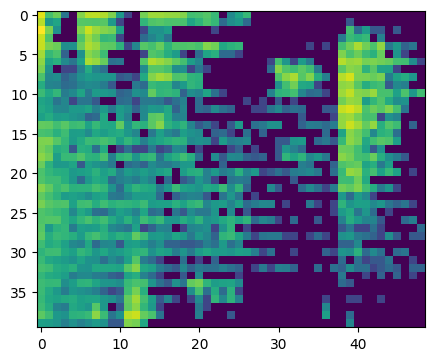

In [8]:
random_number = random.randint(0, len(training_spectrogram) )

print(training_labels[random_number])
plt.figure(figsize=(5 , 5))
plt.imshow( tf.transpose(training_spectrogram[random_number])[0] )
plt.show()

# Create a tensorFlow Data Pipeline

In [9]:
# Should run only one time

# Train
preprocessed_training_dataset = preprocessed_training_dataset.shuffle( buffer_size=len(preprocessed_training_dataset)  )  
                                                                          # .shuffle : means we shuffle نخلط the dataset with
                                                                          # each other, buffer size means the elements that
                                                                          # will be loades to the memory to suffle


preprocessed_training_dataset = preprocessed_training_dataset.batch( cof.BATCH_SIZE )    # batch is a process where multiple samples (data points) are
                                                           # grouped together into a single batch. This batch of samples is
                                                           # then fed into the model simultaneously during training or inference.
                                                           
preprocessed_training_dataset = preprocessed_training_dataset.prefetch( tf.data.AUTOTUNE )   
                                                            # for memory : is used to overlap the preprocessing and model execution
                                                            # of a training step. By prefetching data, you can reduce the
                                                            # time your GPU or CPU spends idle, waiting for data to be
                                                            # loaded and processed, thus improving overall training performance.

# Test
preprocessed_test_dataset = preprocessed_test_dataset.shuffle( buffer_size=len(preprocessed_test_dataset)  )  
preprocessed_test_dataset = preprocessed_test_dataset.batch( 1 )  
preprocessed_test_dataset = preprocessed_test_dataset.prefetch( tf.data.AUTOTUNE )   

In [10]:
preprocessed_training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 49, 40, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [11]:
preprocessed_test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 49, 40, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

(8, 49, 40, 1)
[0. 0. 1. 0.]
float32


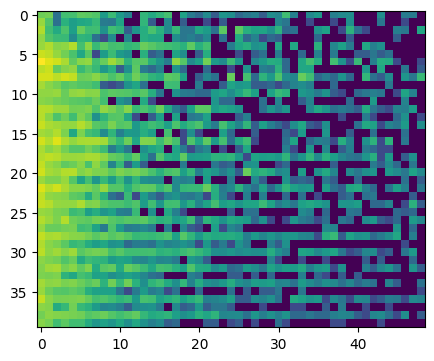

In [12]:
# Grap a sample
sample , lable = preprocessed_training_dataset.as_numpy_iterator().next()

print(sample.shape)
print( (lable[0]) )
print(sample[0][0:10].dtype)
plt.figure(figsize=(5 , 5))
plt.imshow( tf.transpose(sample[0])[0] )
plt.show()

# Make the CNN model

### You should use keras from this library tensorflow_model_optimization.python.core.keras.compat to be able to make quantization

In [13]:
!pip install -q tensorflow-model-optimization
from tensorflow_model_optimization.python.core.keras.compat import keras

# Atomic14 : DIY Alexa model

In [14]:
# My_layer_1 = keras.layers.Input( shape=(cof.SPECTOGRAM_ROW,cof.SPECTOGRAM_COL,1) )
My_layer_1 = keras.layers.InputLayer(input_shape=(cof.SPECTOGRAM_ROW, cof.SPECTOGRAM_COL, 1))

My_layer_2 = keras.layers.Conv2D(filters=8, kernel_size=(3,3),
                                    padding='same',
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    name='conv_layer1')

My_layer_3 = keras.layers.MaxPool2D(name='Max_pooling_1', pool_size=(2,2))

My_layer_4 = keras.layers.Conv2D(filters=8, kernel_size=(3,3),
                                    padding='same',
                                    activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    name='conv_layer2')

My_layer_5 = keras.layers.MaxPool2D(name='Max_pooling_2', pool_size=(2,2))

My_layer_6 = keras.layers.Flatten()

My_layer_7 = keras.layers.Dropout(0.1)

My_layer_8 = keras.layers.Dense(80, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                   name='hidden_layer1')

My_layer_9 = keras.layers.Dropout(0.1)

My_layer_10 = keras.layers.Dense( cof.NUMBER_OF_CLASSES , activation='softmax',
                                   kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                   name='output')

My_model = keras.Sequential([ My_layer_1,My_layer_2,My_layer_3,My_layer_4,My_layer_5,My_layer_6,My_layer_7,My_layer_8,My_layer_9,My_layer_10  ])
My_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 49, 40, 8)         80        
                                                                 
 Max_pooling_1 (MaxPooling2  (None, 24, 20, 8)         0         
 D)                                                              
                                                                 
 conv_layer2 (Conv2D)        (None, 24, 20, 8)         584       
                                                                 
 Max_pooling_2 (MaxPooling2  (None, 12, 10, 8)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0

# Tinyconv model

In [36]:
layer_1 = keras.layers.InputLayer(input_shape=(SPECTOGRAM_ROW, SPECTOGRAM_COL, 1),name='fingerprint_input')

layer_2 = keras.layers.Conv2D( filters=8,  # Adjusted to match the original TensorFlow example
    kernel_size=(10, 8),  # Height x Width
    strides=(2, 2),
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

layer_3 = keras.layers.Dropout(0.2)

layer_4 = keras.layers.Flatten()

layer_5 = keras.layers.Dense(
    units=NUMBER_OF_CLASSES, 
    activation='softmax',  # Changed to 'softmax' as per the example
    name='output'
)


My_model = keras.Sequential([ layer_1,layer_2,layer_3,layer_4,layer_5  ])
My_model.summary()

# View the model layers as a diagram
keras.utils.plot_model(My_model, show_shapes=True)

NameError: name 'SPECTOGRAM_ROW' is not defined

In [ ]:
# """A simple residual block with two convolutional layers."""
# res = x
# x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
# x = layers.BatchNormalization()(x)

# # Skip connection
# if stride != 1 or x.shape[-1] != res.shape[-1]:
#     res = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(res)
#     res = layers.BatchNormalization()(res)

# x = layers.add([x, res])
# x = layers.ReLU()(x)
# return x

# def create_resnet_model(input_shape, num_classes):
# inputs = layers.Input(shape=input_shape)

# # Initial convolutional layer
# x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(inputs)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# # Residual blocks
# x = residual_block(x, filters=64)
# x = residual_block(x, filters=128, stride=2)
# x = residual_block(x, filters=256, stride=2)
# x = residual_block(x, filters=512, stride=2)

# # Global average pooling and output
# x = layers.GlobalAveragePooling2D()(x)
# outputs = layers.Dense(num_classes, activation='softmax')(x)

# model = models.Model(inputs, outputs)
# return model

# # Example usage
# input_shape = (SPECTROGRAM_HEIGHT, SPECTROGRAM_WIDTH, 1)  # Replace with actual spectrogram dimensions
# num_classes = NUMBER_OF_CLASSES  # Replace with the actual number of keyword classes
# model = create_resnet_model(input_shape, num_classes)

# # model.compile(optimizer='adam',
# #           loss='sparse_categorical_crossentropy',
# #           metrics=['accuracy'])

# model.summary()


# Make quanization then compile and fit the model

In [ ]:
# import tensorflow_model_optimization as tfmot  # Used to make quantization


# # q_aware stands for quantization aware
# # It may gives an error, I don't know why, but you can check this notebook it works for the same code, so run this code there
# # https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/quantization/training_example.ipynb#scrollTo=w1mGEh_7A_VZ
# q_aware_model = tfmot.quantization.keras.quantize_model(My_model) # Apply quantization on the model


# # Compile model using the quatized model

# # BinaryCrossentropy : is used for binary classification for 1 class
# # CategoricalCrossentropy : is used for one hot multiclass classification
# # sparse_softmax_cross_entropy : 
# q_aware_model.compile( optimizer=keras.optimizers.Adam(learning_rate=START_LEARNING_RATE) , loss=keras.losses.CategoricalCrossentropy(),  metrics= ['accuracy' , 
#                                                                                                  keras.metrics.TruePositives(name='TP')  ,
#                                                                                                  keras.metrics.TrueNegatives(name='TN')  ,
#                                                                                                  keras.metrics.FalsePositives(name='FP') ,
#                                                                                                  keras.metrics.FalseNegatives(name='FN') ,
#                                                                                                  keras.metrics.Precision(name='pre') 
#                                                                                                ]   )


# q_aware_model.summary()
# My_model = q_aware_model

In [ ]:
# history = q_aware_model.fit( train , epochs=50  , callbacks=[scheduler_callback] )

# Callbacks

### scheduler callback

In [15]:
def scheduler(a_epoch,a_learning_rate):

    if( a_epoch < cof.LEARNING_RATE_EPOCH_CHANGE ):
        return a_learning_rate
    else:
        return a_learning_rate * tf.math.exp(-0.1) 

scheduler_callback = tf.keras.callbacks.LearningRateScheduler( scheduler , verbose=1 ) # verbose=0: No logging output will be displayed.
                                                                                    # verbose=1: The current learning rate will be printed at the end of each epoch.
                                                                                    # verbose=2: The current learning rate will be printed at the beginning of each epoch.

# Train Model

In [ ]:
My_model.compile( optimizer=keras.optimizers.Adam(learning_rate=cof.START_LEARNING_RATE) , loss=keras.losses.CategoricalCrossentropy(),  metrics= ['accuracy' , 
                                                                                                 keras.metrics.TruePositives(name='TP')  ,
                                                                                                 keras.metrics.TrueNegatives(name='TN')  ,
                                                                                                 keras.metrics.FalsePositives(name='FP') ,
                                                                                                 keras.metrics.FalseNegatives(name='FN') ,
                                                                                                 keras.metrics.Precision(name='pre') ,
                                                                                                 keras.metrics.Recall(name='re') ,
                                                                                                 keras.metrics.F1Score(name='f1') 
                                                                                               ]  ) 

history = My_model.fit( preprocessed_training_dataset , validation_data=preprocessed_test_dataset  , epochs=10 )   

Epoch 1/10
1372/1372 [==============================] - 39s 13ms/step - loss: 0.5258 - accuracy: 0.8551 - TP: 9233.0000 - TN: 31484.0000 - FP: 1426.0000 - FN: 1737.0000 - pre: 0.8662 - re: 0.8417 - f1: 0.8502 - val_loss: 0.3266 - val_accuracy: 0.9265 - val_TP: 3781.0000 - val_TN: 12062.0000 - val_FP: 268.0000 - val_FN: 329.0000 - val_pre: 0.9338 - val_re: 0.9200 - val_f1: 0.9330
Epoch 2/10
1372/1372 [==============================] - 17s 12ms/step - loss: 0.2988 - accuracy: 0.9325 - TP: 10191.0000 - TN: 32221.0000 - FP: 689.0000 - FN: 779.0000 - pre: 0.9367 - re: 0.9290 - f1: 0.9302 - val_loss: 0.2809 - val_accuracy: 0.9338 - val_TP: 3820.0000 - val_TN: 12079.0000 - val_FP: 251.0000 - val_FN: 290.0000 - val_pre: 0.9383 - val_re: 0.9294 - val_f1: 0.9400
Epoch 3/10
1372/1372 [==============================] - 17s 12ms/step - loss: 0.2554 - accuracy: 0.9462 - TP: 10336.0000 - TN: 32370.0000 - FP: 540.0000 - FN: 634.0000 - pre: 0.9503 - re: 0.9422 - f1: 0.9443 - val_loss: 0.2679 - val_accu

# Evaluate model

In [33]:
result = My_model.evaluate( preprocessed_test_dataset )

1112/1112 [==============================] - 2s 2ms/step - loss: 0.3121 - accuracy: 0.9397 - TP: 1043.0000 - TN: 3272.0000 - FP: 64.0000 - FN: 69.0000 - pre: 0.9422 - re: 0.9379 - f1: 0.9445


## Make a confusion matrix

35/35 [==============================] - 1s 6ms/step


NameError: name 'itertools' is not defined

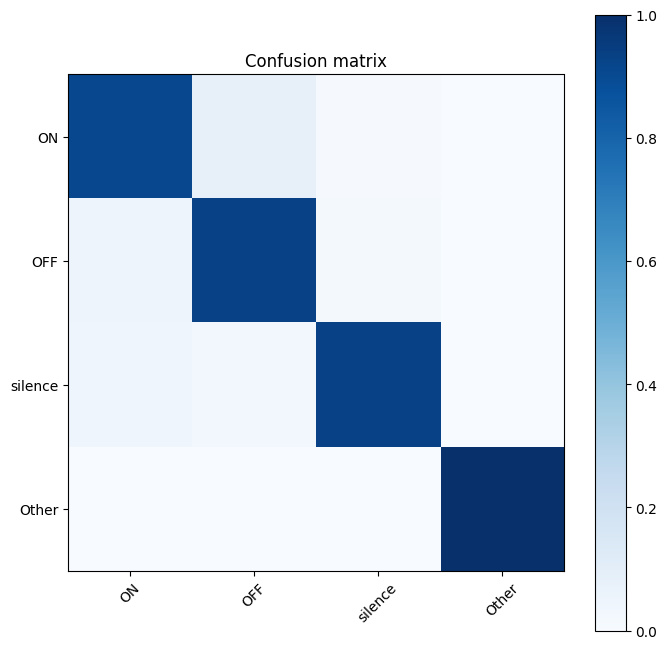

In [34]:
My_lable = []
My_data  = []
threshold = 0.8

for data,lable in preprocessed_test_dataset.as_numpy_iterator():
    My_data.append(data[0])
    My_lable.append(lable[0])

    
My_data  = np.array( My_data )    
My_lable = np.array( My_lable )   

My_prediction = My_model.predict( My_data )


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

cm = tf.math.confusion_matrix(
    labels=tf.argmax( My_lable , 1), predictions=tf.argmax(My_prediction, 1)
)

plot_confusion_matrix(cm, ['ON', 'OFF' , 'silence','Other'])

## ROC plot

### Ploting a ROC curve, which is the relation between True positive and False positve at each threshold, to know the suitable threshold for my application

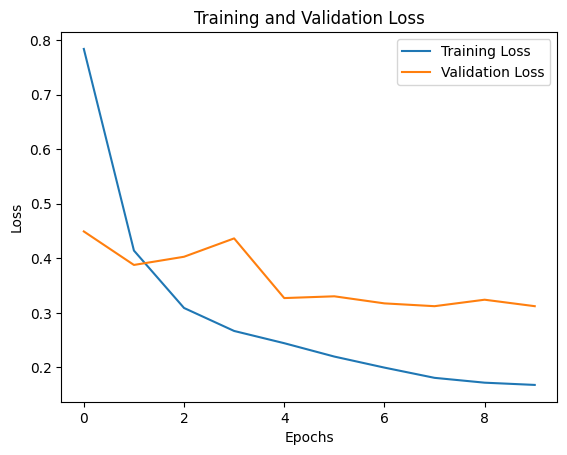

In [35]:
# Plotting the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Adding title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

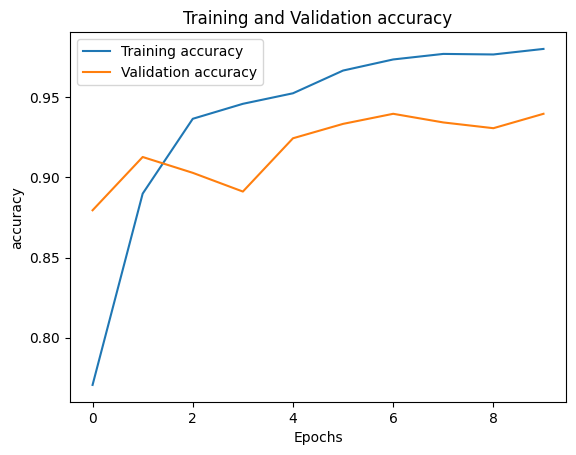

In [36]:
# Plotting the training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')

# Adding title and labels
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# Show the plot
plt.show()

# Convert model to lite model

### Quantization aware training method

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.inference_input_type  = tf.compat.v1.lite.constants.INT8
# converter.inference_output_type = tf.compat.v1.lite.constants.INT8

# q_aware_model_lite = converter.convert()

# # Save the TensorFlow Lite model to a file
# with open("Q_aware_lite_model2.tflite", "wb") as f:
#     f.write(q_aware_model_lite)

In [ ]:
# !xxd -i Q_aware_lite_model2.tflite > model_data.cc

In [ ]:
# import pathlib

# print( f"Our lite model size = {len(q_aware_model_lite)}" )

# # Save the lite model in .tflite file
# tflite_model_file = pathlib.Path('model.tflite') # Creates a Path object representing a file path
# tflite_model_file.write_bytes(q_aware_model_lite) # Write my TensorFlow Lite model in .tflite file

### Save model in a .keras file

In [ ]:
# import tensorflow as tf

# # Assume `model` is your TensorFlow model
# keras_model_path = 'Q_aware_lite_model.keras'

# # Save the model in native Keras format
# q_aware_model.save(keras_model_path)

In [ ]:
# !xxd -i Q_aware_lite_model.keras > Q_model_data.cc

### Load a model

In [ ]:
# import tensorflow as tf

# # Path to the model saved in native Keras format
# keras_model_path = 'path_to_save_model.keras'

# # Load the model
# q_aware_model = tf.keras.models.load_model(keras_model_path)

# Run our lite model to test it using interpreter

In [ ]:
# # Load TFLite model and allocate tensors.
# interpreter = tf.lite.Interpreter(model_content=q_aware_model_lite) # pass our lite model to the interpreter
# interpreter.allocate_tensors() # This method allocates memory for the model's input and output tensors based on the model structure.

# # Get input and output details.
# input_details = interpreter.get_input_details()   # This retrieves a list of dictionaries containing information about the model's input tensors, such as their shape, data type, and index.
# output_details = interpreter.get_output_details() # This retrieves a list of dictionaries containing information about the model's output tensors, similar to the input details.

# print(input_details)
# print('\n')
# print(output_details)

# print( f"The input shape is  {input_details[0]['shape']},  and it's datatype is {input_details[0]['dtype']} " )
# print( f"The output shape is {output_details[0]['shape']}, and it's datatype is {output_details[0]['dtype']} " )

# Post training

### save model

In [37]:
# Saving my model in a dir
export_dir = 'saved_model' # The dir that I will store my model in
tf.saved_model.save( My_model , export_dir)

In [38]:
spectrograms = np.array(training_spectrogram)

training_spectrogram.shape

(2888, 49, 40, 1)

In [39]:
# Convert model to flat buffer format
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# converter.target_spec.supported_ops = tf.compat.v1.lite.constants.INT8

# Choose what optimization we want
#       OPTIMIZE_FOR_SIZE     --> (Hybrid operations) its convert heavy operations to int8 bits
#                                 but senstive operations keep it float32
#                                 and it doesn't quantize activations, it works with wights only
#                                 so it's accuracy is high
#                                 but can't use TPU with it
#                                 2-3x speedup
#       DEFAULT               --> quantive both weights and activations, and it fully quantize all 
#                                 weights.
#                                 can be used with TPU
#                                 4x seedup
#       OPTIMIZE_FOR_LATENCY  --> optimize the latency(speed) of the model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# TensorFlow lite calibrate the quatization to the right scalling, which means it measures the
# dynamic range to quantive correctly
# So we pass some sample of the data to it 
def representative_dataset_gen():
    for i in range(0, len(training_spectrogram), 10):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [training_spectrogram[i:i+10].astype("float32")]

# Pass representaative dataset to the converter        
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_dataset_gen)

# If there is an operation that doesn't support quantzation, it will keep it in float32 formate
# So this line will gives an error if it happens, to make sure that it is fully quantized
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
converter.inference_input_type  = tf.compat.v1.lite.constants.INT8
converter.inference_output_type = tf.compat.v1.lite.constants.INT8

tflite_quant_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 9, Total Ops 20, % non-converted = 45.00 %
 * 9 ARITH ops

- arith.constant:    9 occurrences  (f32: 8, i32: 1)



  (f32: 2)
  (f32: 2)
  (f32: 2)
  (f32: 1)
  (f32: 1)
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


82640

In [40]:
!xxd -i converted_model.tflite > model_data.cc

In [ ]:
!cat model_data4.cc

# Pridict

In [ ]:
# TFLM_yes=[-43,-128,-128,-128,-128,-128,-128,57,64,55,-128,-50,-128,-128,-3,26,1,-50,-26,-60,-60,-128,-128,-29,-18,-7,-50,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-33,56,52,20,-8,-128,-77,8,5,-10,-77,-128,-128,-128,-128,-128,-12,1,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-18,-12,42,42,13,-77,-128,-37,37,-128,-128,-128,-128,-128,-128,-128,-128,-26,-50,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-50,30,8,-20,-128,-128,-128,-23,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-37,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-33,-128,-128,-128,-128,-77,29,-14,-23,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-50,-43,29,11,-33,-128,-128,-2,37,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-33,-33,-128,-128,-128,-37,-37,-128,-128,-77,-29,-128,-128,0,30,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-37,-29,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-60,32,36,-128,-16,-37,-77,-43,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,30,50,20,-18,-18,16,7,-29,-10,12,-1,-29,-128,-128,-29,-16,-12,-8,22,-20,-77,-20,-4,-23,16,-10,-33,-37,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-4,-29,38,58,19,-1,-128,-43,-128,-128,-128,-43,-128,-128,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-18,-128,3,9,35,29,-128,-33,-50,-128,0,-60,-128,-128,11,28,-37,37,-18,-77,7,22,36,-20,23,17,-33,30,5,-20,-43,-128,-128,-128,-128,-128,-128,-128,-128,-128,-16,-18,-14,-29,-50,-128,-128,-128,-128,-128,-128,-128,-128,-60,19,27,-77,-128,-16,-128,-128,-50,-50,-128,-77,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-10,-128,-128,-77,38,17,23,6,-128,-128,3,-37,8,18,26,15,-33,-128,-128,-128,-26,9,-3,6,-33,-128,-128,21,42,16,-128,-23,-60,-128,-128,-128,-128,-128,-128,-128,-33,-128,-128,-128,12,-60,18,-16,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-77,-128,-128,-128,-18,-128,-128,-128,-128,-128,-128,-77,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-26,6,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,4,23,-2,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-43,-14,-128,-60,24,22,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-60,21,50,51,60,47,18,-128,-128,-128,-128,-128,31,-10,-60,-14,45,52,23,20,-7,43,13,-37,-26,-37,-20,-128,-77,-18,-2,12,-23,-18,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,0,-77,-128,-128,-128,-128,-37,23,3,-16,-128,-128,-77,1,45,52,45,20,7,-16,-128,-2,38,10,-128,-23,23,-1,-18,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-50,23,-8,0,-50,-128,-12,31,35,51,5,3,-18,-128,-50,-7,-60,-77,-3,-37,-12,3,8,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-37,-33,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,25,-1,-29,-43,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-26,-8,21,7,-50,-128,-128,-128,-128,-77,-26,-77,-77,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-77,-128,20,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-29,-128,-50,-29,-23,-77,-128,-60,-128,-77,3,11,-26,-29,-128,-43,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,0,-50,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-77,-128,-128,-128,10,10,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-2,-33,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-8,28,-128,-128,-128,-50,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-43,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,4,24,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-50,29,39,1,-37,-128,-128,-128,-128,-128,-128,-128,-128,37,41,-128,-33,-77,-128,-128,-128,-128,-128,-50,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,17,11,-23,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-43,-128,-128,-128,-128,-2,-8,41,37,1,-128,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,26,16,41,36,36,-128,-128,-60,-50,-128,22,59,45,56,60,63,42,-128,15,16,45,56,52,45,40,6,0,2,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-23,-26,-128,-128,-18,8,20,-77,-128,-128,-128,-20,-60,-128,-128,-29,-128,-128,-128,-37,-128,-60,-20,-6,-6,-77,-37,-128,-128,-128,-77,-128,-29,1,8,53,59,-7,42,20,-77,-23,-7,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-77,-37,-128,-128,-60,-77,7,23,13,-128,-77,36,32,36,27,-128,-29,-7,-128,-23,-128,-128,-128,-16,14,-37,-4,-3,-128,-33,-128,-128,-128,-60,-128,-128,-128,-128,-128,-128,-60,-60,-50,-128,-128,-4,48,23,5,15,-12,-20,16,45,-10,-6,0,-128,-128,-33,-33,-128,-50,-77,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-60,-60,16,8,46,50,40,-77,-128,-128,-128,-128,-43,-50,-128,-128,-128,3,44,25,40,32,16,-37,-128,-77,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-33,-29,39,40,14,-37,-6,-37,-128,-37,-128,-128,-128,-128,-128,-128,-128,-4,72,47,43,51,12,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-29,-37,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-33,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-60,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128]
TFLM_yes=[-60,-43,-128,-128,-77,-8,32,-14,-7,45,27,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-50,-128,-128,-77,20,39,45,26,48,27,-77,-60,-18,-128,-128,-128,-128,-128,-128,-128,-128,-128,-12,15,-14,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-8,-33,-128,-128,-128,-128,-60,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-6,-128,-128,-37,-37,33,12,-12,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-50,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-6,-128,-128,-128,-128,-128,-128,-128,-37,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-26,33,32,-128,-128,-128,-128,-128,-60,28,57,-18,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,26,27,-128,-128,-128,-128,-128,35,69,62,14,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-43,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,4,8,-128,-128,-128,-128,-128,48,75,85,45,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-16,5,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-50,1,25,-128,-128,-128,-128,-77,56,53,70,51,23,35,58,29,-43,-77,-77,-50,-60,-128,-128,0,-43,-128,-128,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-23,-128,-128,-128,-128,1,53,19,42,29,-60,10,47,10,11,6,20,17,2,-77,-33,-23,-128,-37,-128,-18,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-18,-128,-33,-128,-60,36,35,-128,40,-12,13,-1,14,-60,9,-2,59,55,58,16,12,3,-18,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-3,37,39,16,-2,-128,-128,-18,-128,-77,-33,-60,-128,-60,6,65,72,80,35,47,40,11,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-50,47,51,-7,-50,-128,-128,-128,-23,-128,-43,-128,-128,-128,-128,-128,-18,28,81,55,-128,-128,-23,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-60,48,58,-26,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,15,51,86,49,-43,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,18,34,40,30,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,50,52,50,-77,-20,-37,-128,-128,-128,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-60,-20,-43,-128,-128,-128,-128,-128,-128,-128,-128,-128,30,25,-128,-50,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-14,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-50,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-37,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-37,-77,-3,-18,-128,-128,-128,-128,-128,-26,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-29,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-37,-37,7,-128,-60,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-60,-128,-128,-128,-128,33,62,-2,22,7,-10,-77,-128,-128,-128,-128,-128,-128,-128,-128,72,86,71,80,74,18,-128,-128,-77,28,62,11,-128,-128,-128,-128,-128,-128,-128,-128,-60,-128,-128,-128,-60,13,40,19,38,-7,-29,-29,11,-50,-26,-128,-50,-128,-128,-33,63,80,72,86,75,55,5,-43,-12,-10,58,66,-23,-128,-128,-128,-128,-128,-43,-128,-43,-50,-77,-128,-128,-128,-37,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-26,-50,38,-16,33,-128,-128,-128,-128,-23,-10,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-23,52,44,-37,-26,-60,-128,-128,-128,-128,-128,-77,-128,-128,-128,-77,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-33,-60,-128,-128,-23,-50,-128,-128,-128,-128,-128,-128,-7,-128,-23,-77,-128,-128,-18,-128,-43,-128,-23,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-77,-128,-50,-128,-128,-128,-128,-128,-128,-128,-128,-128,-18,-50,-128,-77,-60,-16,-37,-128,-128,-128,4,-20,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-26,-128,-37,38,-60,55,25,38,-43,-3,-128,-128,-128,-128,-10,11,-20,-33,-77,-20,-37,-77,-128,-128,-128,-43,5,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,15,-128,-43,-7,48,63,-128,-37,18,52,-128,-128,-128,0,15,15,-4,-128,15,33,29,-18,-128,-60,-128,-60,14,-128,-128,-128,-128,-128,-128,-128,-128,-77,-77,-128,-128,-128,-128,-128,-128,-128,-33,24,-128,-128,-128,-33,-128,-128,-128,-128,-50,-2,-128,-128,-128,-128,-12,-128,-128,-10,-60,-77,-8,-7,-128,-43,0,38,13,-43,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-29,-128,-128,-128,-128,-128,-128,-77,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128,-128]
TFLM_silence_q = [-66,-113,-114,-103,-92,-108,-110,-86,-81,-82,-78,-73,-68,-67,-76,-90,-88,-63,-42,-55,-50,-42,-29,-20,-44,-47,-27,-14,-15,-6,-7,-15,-3,5,-2,-3,10,12,14,7,8,31,40,36,38,59,73,75,79,79,88,87,89,86,69,81,89,81,83,91,97,91,99,106,91,85,92,94,85,78,78,91,98,89,62,49,51,40,39,33,25,21,26,3,-8,-6,-5,-5,-22,-19,-11,-28,-36,-48,-53,-57,-65,-75,-96,-93,-89,-100,-107,-110,-102,-95,-101,-114,-105,-86,-84,-95,-94,-74,-64,-74,-98,-109,-89,-79,-75,-73,-75,-55,-43,-50,-50,-45,-37,-30,-39,-45,-26,-16,-21,-12,-33,-42,-24,-22,-11,9,28,45,44,45,36,23,27,28,13,17,24,15,25,30,9,3,6,10,16,6,8,13,29,50,40,25,30,27,12,10,25,0,-1,10,0,2,9,-4,0,0,-5,-6,-20,-32,-22,-28,-43,-49,-62,-51,-32,-40,-40,-41,-49,-48,-54,-45,-46,-57,-53,-59,-70,-60,-59,-74,-60,-47,-56,-72,-81,-71,-78,-84,-77,-71,-66,-46,-47,-49,-36,-46,-46,-44,-55,-57,-54,-48,-48,-43,-28,-31,-24,-14,-16,2,13,8,12,15,10,10,21,12,7,27,32,31,40,33,27,34,36,37,32,29,26,25,19,15,21,35,39,32,25,20,21,4,-15,-17,-15,-10,-14,-23,-24,-15,-26,-32,-45,-46,-34,-44,-53,-45,-49,-54,-48,-54,-68,-66,-69,-65,-62,-82,-89,-87,-85,-87,-85,-74,-65,-63,-48,-41,-37,-27,-32,-34,-40,-45,-43,-46,-40,-32,-29,-28,-32,-27,-31,-28,-31,-34,-26,-18,-23,-29,-37,-48,-22,-18,-33,-32,-27,-18,-13,-20,-27,-27,-22,-32,-52,-44,-42,-44,-34,-34,-39,-37,-38,-50,-48,-43,-48,-51,-45,-34,-24,-22,-38,-53,-62,-50,-36,-37,-33,-32,-40,-38,-38,-48,-40,-33,-34,-22,-12,-12,-18,-17,-32,-32,-27,-42,-46,-42,-34,-27,-25,-25,-41,-53,-46,-29,-16,-29,-46,-36,-19,-27,-34,-25,-5,3,-8,-11,-5,-18,-20,-32,-37,-19,-12,-18,-17,-12,-3,-1,-11,-11,-7,-7,0,0,0,7,8,0,-4,-5,-9,-15,-11,-9,-11,-11,-29,-26,-15,-12,-1,-13,-19,-10,-10,-11,-34,-34,-20,0,-34,8,6,-130,59,-209,-24,75,-180,86,-271,54,9,-307,327,-268,104,172,-96,133,-6,-85,-97,93,-143,21,-64,-29,75,121,-54,-41,123,-118,186,-51,-126,178,-35,172,160,15,107,33,-70,75,9,73,185,16,60,71,4,129,60,126,133,54,104,4,44,22,14,70,0,53,31,29,44,29,-69,4,-16,0,70,29,45,0,45,9,3,36,0,52,16,-30,-14,0,-29,-19,-31,-42,3,-11,-15,-25,-46,-8,0,-30,-40,-32,-58,-53,-66,-102,-78,-96,-89,-70,-73,-47,-46,-45,-41,18,37,2,18,-1,3,14,-2,-21,-27,-35,-35,-20,-31,14,34,17,47,60,85,86,86,83,88,103,106,119,118,117,125,135,143,140,134,118,108,115,136,136,100,110,131,130,113,74,76,74,62,46,11,3,19,29,-1,-21,-5,-6,-6,-7,-24,-33,-9,-39,-54,-67,-63,-45,-40,-25,-67,-82,-108,-103,-77,-95,-77,-67,-57,-62,-63,-56,-71,-63,-55,-63,-80,-72,-48,-21,-8,-18,-32,-40,-60,-61,-59,-57,-43,-27,-18,-23,-25,-52,-41,-12,-9,-3,-15,-24,5,17,7,12,22,31,32,43,55,76,77,54,50,44,67,53,33,37,29,54,49,28,38,40,49,42,58,55,38,45,-1,-10,9,-11,-16,-27,-13,2,8,0,-14,-13,-27,-21,-12,-38,-23,-34,-42,-30,-41,-25,-50,-46,-34,-48,-28,-43,-54,-37,-30,-34,-29,-18,-16,-22,-21,-13,-15,-13,-23,-30,-5,-21,-36,-30,-25,-1,-12,0,9,-7,-7,-21,-18,-28,-34,-25,-40,-41,-29,-46,-64,-51,-32,-23,-7,-11,-22,-13,-22,-17,-19,-38,-14,-3,-9,-12,-32,-16,-20,-20,-5,5,20,22,9,0,14,36,44,21,25,34,24,23,19,17,19,24,26,33,39,39,51,53,45,45,47,40,29,22,29,21,7,3,-3,-8,4,2,6,1,-14,-9,-18,4,8,2,1,-9,-9,-14,-10,-23,-30,-23,-38,-26,-21,-14,-26,-34,-33,-32,-12,-15,-17,-22,-29,-15,-12,-27,-29,-41,-54,-39,-29,-43,-55,-41,-42,-37,-42,-53,-52,-46,-35,-42,-49,-56,-56,-56,-44,-41,-55,-25,-5,-6,0,-10,-20,-21,6,1,-15,-7,-20,-20,18,14,-14,0,2,3,4,-12,-12,8,1,-1,8,-2,15,30,7,22,27,11,17,15,13,0,-14,-7,-24,-26,-19,-9,7,-10,-19,0,-7,-1,-12,-17,-17,-28,-10,-7,-14,-21,-20,-15,-38,-49,-43,-40,-58,-72,-71,-58,-52,-66,-72,-63,-59,-67,-68,-70,-79,-79,-74,-80,-80,-69,-92,-109,-120,-130,-119,-122,-118,-116,-122,-131,-140,-149,-136,-114,-106,-112,-128,-124,-104,-103,-102,-99,-94,-90,-85,-85,-94,-87,-82,-72,-59,-74,-81,-66,-54,-51,-55,-59,-52,-64,-61,-35,-45,-39,-14,-28,-42,-48,-45,-50,-44,-33,-43,-53,-47,-28,-36,-35,-22,-21,-5,-1,-19,-24,-8,-12,-10,8,12,0,14,31,32,44,40,44,55,43,29,40,49,27,37,52,44,34,49,70,60,46,41,43,49,37,28,25,39,33,20,20,6,23,7,-20,-6,-2,-13,-15,-30,-44,-46,-65,-66,-63,-61,-47,-63,-67,-60,-60,-50,-82,-109,-105,-108,-103,-99,-99,-98,-96,-89,-79,-58,-57,-56,-64,-75,-66,-60,-61,-63,-49,-76,-89,-76,-70,-46,-65,-60,-27,-15,-11,-26,-35,-16,-8,-17,-18,-19,-7,14,6,0,5,10,20,12,20,12,-4,-3,-16,0,19,14,-12,-14,6,9,24,17,1,-1,-7,-15,-24,-22,-11,-15,-13,-7,-16,-6,-7,-7,-9,-2,1,-16,-23,-6,-10,-25,-27,-24,-5,-13,-17,-27,-32,-17,-27,-36,-25,-20,-22,-22,-23,-12,-16,-26,-7,-9,-25,-25,-7,-30,-39,-36,-42,-38,-34,-31,-36,-26,-22,-17,-17,-30,-34,-8,2,-8,-17,-20,-8,-16,-37,-17,-3,-15,-12,-3,10,15,14,20,30,43,54,51,44,43,39,42,40,45,57,47,45,44,43,53,63,59,69,76,75,66,63,90,97,88,83,70,72,72,60,60,66,55,51,51,39,20,23,15,9,30,29,21,17,2,4,15,17,10,1,-9,-5,-17,-29,-24,-12,0,-10,-26,-22,-9,-31,-49,-45,-43,-31,-36,-45,-53,-42,-40,-55,-56,-41,-31,-41,-45,-32,-21,-19,-12,-7,-8,-8,0,-2,0,4,-7,-8,6,16,5,-1,-4,0,9,10,15,29,38,51,52,36,32,31,43,41,41,74,80,79,80,80,77,70,77,64,73,91,101,117,92,96,109,106,113,103,108,125,150,165,138,126,131,128,115,105,108,119,122,123,117,109,125,125,112,110,108,99,76,73,65,73,69,52,57,52,46,42,50,53,47,63,60,31,29,29,18,17,16,21,21,9,0,-10,11,24,14,-4,-19,-1,2,-4,-7,-9,-17,-24,-32,-45,-32,-23,-36,-41,-46,-43,-32,-25,-30,-23,-4,-4,-29,-31,-21,-3,10,-4,0,5,3,0,-12,-7,-7,-23,-30,-26,-14,-11,-11,-23,-21,-4,-13,-15,-8,0,16,16,22,34,40,40,39,39,37,28,15,12,21,23,9,6,6,19,17,11,15,19,33,37,43,44,45,42,33,24,24,31,33,30,30,2,5,8,-14,-3,17,25,21,12,15,36,30,27,18,1,-2,-1,-7,-31,-36,-33,-45,-39,-31,-25,-22,-20,-29,-42,-51,-41,-45,-65,-71,-69,-62,-56,-63,-84,-79,-79,-85,-89,-96,-86,-87,-91,-96,-101,-86,-83,-92,-94,-105,-106,-93,-81,-85,-72,-55,-59,-68,-71,-56,-55,-52,-47,-52,-42,-38,-54,-60,-63,-50,-38,-55,-57,-43,-24,-22,-27,-16,-17,-26,-19,-3,5,0,-1,-4,-3,-5,-4,-19,-19,5,-2,-3,12,9,0,2,-17,-22,-10,-26,-18,-14,-11,-9,-34,-25,-7,0,20,0,-30,-18,-7,-4,-2,0,-1,-13,-8,-4,-1,11,7,-23,-31,-32,-56,-48,-55,-64,-45,-42,-50,-49,-36,-29,-37,-46,-57,-50,-61,-75,-44,-58,-71,-50,-65,-69,-62,-67,-42,-36,-55,-35,-51,-66,-39,-35,-11,-16,-29,0,-15,-21,0,-12,0,6,-9,12,18,24,41,23,14,24,24,51,68,54,66,63,68,81,62,68,86,84,86,76,47,37,53,74,75,50,42,47,55,55,41,42,36,12,15,21,24,39,28,30,30,8,18,26,34,33,23,22,23,10,13,11,-17,-2,7,-6,0,-7,-24,-16,0,-10,-37,-23,-21,-26,-17,-23,-25,-31,-48,-43,-41,-53,-44,-46,-32,-30,-59,-61,-54,-46,-25,-23,-41,-24,-21,-32,-34,-39,-30,-17,-5,-6,-26,-10,-2,-31,-15,4,-10,-20,-20,2,34,20,-11,-1,10,21,13,-9,19,23,18,33,25,23,22,36,42,37,52,47,33,31,35,40,41,52,45,40,54,47,39,60,64,71,83,77,82,76,67,59,57,72,67,40,55,79,57,53,62,49,43,56,59,26,34,42,10,15,3,-19,-9,-15,-29,-16,-13,-21,-7,-11,-24,-14,-16,-22,-14,-20,-39,-47,-46,-58,-49,-34,-45,-38,-24,-25,-21,-25,-23,-8,-7,-22,-26,-9,-14,-9,-11,-29,-12,-5,-13,19,21,-3,5,9,9,5,2,13,9,17,6,-16,0,5,4,5,-8,-12,-4,5,-5,-11,-12,-6,16,2,-10,16,25,23,32,36,55,41,31,37,27,22,20,10,18,40,51,47,33,17,22,36,34,36,31,35,39,32,37,52,62,53,54,59,55,42,30,32,35,44,36,40,48,50,58,35,31,40,42,44,34,36,48,29,30,49,40,40,34,24,45,25,-5,4,6,22,41,16,16,36,37,30,16,24,36,26,30,27,21,32,41,35,36,39,36,42,41,36,43,47,47,49,47,36,25,25,24,30,22,19,22,17,9,6,5,11,21,12,17,20,35,44,42,44,37,43,42,30,37,34,6,5,13,10,30,10,-15,-2,6,12,20,0,0,24,12,8,8,2,5,11,21,32,38,29,23,17,6,1,3,4,12,19,6,13,14,18,13,7,10,3,7,4,7,-3,-10,-9,-5,1,-24,-27,-17,-22,-21,-15,-26,-13,-7,-16,-7,-18,-18,-4,-7,-15,-30,-24,0,17,18,-8,-35,-29,-22,-14,-4,-28,-33,-26,-27,-18,-22,1,-4,-11,-2,-10,-7,1,0,3,8,12,12,0,12,28,9,28,24,11,25,17,15,28,41,51,41,25,28,35,30,22,26,52,46,5,7,19,21,37,11,7,31,15,-10,2,17,4,9,-5,-19,1,20,3,-1,-3,0,17,-9,-25,-2,-8,-3,-18,-52,-44,-50,-67,-61,-60,-42,-45,-69,-70,-63,-73,-79,-78,-80,-71,-76,-77,-55,-64,-64,-68,-76,-62,-65,-70,-77,-79,-63,-56,-90,-94,-55,-66,-70,-53,-53,-46,-43,-72,-78,-62,-55,-46,-53,-58,-52,-56,-65,-51,-50,-50,-49,-60,-39,-40,-45,-31,-50,-60,-30,-29,-28,-20,-29,-25,-26,-34,-23,-30,-35,-24,-30,-33,-41,-41,-24,-18,-19,-18,-27,-37,-41,-41,-31,-40,-46,-48,-57,-50,-49,-59,-60,-56,-56,-58,-74,-68,-51,-61,-53,-43,-56,-68,-63,-46,-57,-69,-75,-73,-70,-82,-71,-59,-63,-55,-64,-84,-70,-64,-68,-71,-72,-57,-60,-79,-74,-56,-46,-45,-66,-52,-41,-39,-19,-39,-57,-23,-12,-27,-28,-21,-5,-14,-16,0,3,14,15,-4,-8,7,6,1,16,26,28,21,21,22,23,34,28,15,18,5,-4,3,0,5,13,-1,0,0,-4,-6,-14,-12,-19,-20,-14,-24,-33,-43,-43,-29,-30,-41,-60,-63,-39,-44,-55,-70,-78,-74,-60,-63,-78,-50,-49,-67,-66,-67,-65,-72,-76,-67,-69,-64,-67,-62,-45,-60,-62,-50,-64,-59,-48,-53,-32,-41,-51,-57,-70,-59,-73,-69,-40,-58,-67,-45,-37,-27,-17,-20,-13,-8,2,5,-3,-8,0,13,6,-9,-23,-24,-18,0,6,15,32,43,59,57,53,46,42,49,56,72,79,82,82,78,81,78,69,75,70,61,80,96,78,68,70,59,72,66,45,57,51,37,33,25,26,32,18,12,27,41,43,12,3,24,13,1,-1,-7,-4,-2,-1,-9,-10,-6,-19,-16,-3,-1,-10,-20,-21,-2,-2,-25,-26,-17,-16,-29,-36,-30,-38,-41,-48,-46,-18,-20,-28,-28,-37,-27,-19,-24,-23,-31,-31,-14,-10,-12,-19,-11,10,-9,-17,0,2,11,19,20,30,26,13,33,43,45,54,50,57,66,75,84,78,71,71,69,77,86,79,84,75,76,90,79,86,102,97,107,112,102,107,111,99,98,99,99,97,89,64,58,75,84,92,70,71,95,88,69,71,65,54,43,28,33,29,31,33,17,24,34,19,14,16,9,19,18,11,12,7,13,1,-9,7,23,33,33,23,20,23,24,20,17,15,14,8,4,14,21,27,31,14,6,15,13,3,-3,-2,3,14,10,2,12,21,14,9,13,12,18,14,8,14,17,7,0,-19,-27,-19,-22,-25,-21,-28,-28,-17,-14,-18,-23,-5,-2,-9,7,15,16,1,0,0,-9,-2,-10,0,19,30,36,32,38,56,64,51,59,54,38,41,27,16,18,18,28,32,39,49,42,36,22,18,24,19,2,-9,7,30,24,13,9,9,4,1,0,0,0,0,0,-9,-13,-26,-31,-30,-27,-21,-22,-15,-23,-26,-27,-36,-26,-26,-35,-39,-50,-46,-33,-40,-27,-8,-22,-36,-53,-45,-19,-9,-16,-10,-2,8,26,11,8,23,21,23,23,10,18,17,6,33,40,29,28,13,30,54,42,31,24,27,38,27,22,30,17,13,10,14,28,24,18,30,34,34,37,30,34,52,53,44,33,29,34,24,8,-2,4,23,39,42,27,32,44,37,16,15,15,0,-16,-5,16,9,-2,-16,-17,-9,0,-13,-22,-17,-29,-33,-30,-54,-62,-51,-73,-70,-77,-82,-60,-67,-67,-62,-55,-52,-55,-63,-78,-80,-70,-66,-77,-79,-84,-82,-71,-78,-86,-79,-78,-80,-83,-76,-61,-54,-50,-50,-50,-61,-65,-50,-61,-72,-61,-48,-43,-39,-35,-13,-10,-29,-28,-37,-34,-28,-41,-30,-6,5,6,0,-3,5,4,0,-5,-16,1,10,11,8,-2,-10,-18,-24,-21,3,9,-17,-12,1,9,12,2,-5,-6,-15,-16,-15,-23,-25,-24,-20,-26,-36,-32,-25,-34,-26,-27,-34,-7,-2,-15,-18,-18,-19,-27,-38,-25,-19,-28,-22,-15,-18,-28,-26,-26,-38,-39,-30,-26,-24,-25,-10,0,-7,-15,-21,-22,-24,-28,-34,-30,-27,-32,-43,-43,-24,-29,-34,-27,-28,-21,-31,-50,-51,-53,-39,-30,-30,-9,0,-3,-10,0,0,-6,0,-11,-18,-11,-3,-7,-15,6,15,9,8,12,23,29,15,0,11,5,10,18,12,10,9,14,20,25,16,7,18,21,13,2,5,5,7,23,15,3,5,8,2,-14,-17,-4,0,-15,-31,-43,-41,-25,-28,-43,-42,-41,-29,-39,-55,-57,-59,-48,-56,-51,-25,-26,-20,-10,-24,-31,-24,-22,-22,-17,-14,-15,-24,-18,-12,-4,-3,-8,-10,-17,-17,-8,2,4,12,33,36,32,42,35,18,17,29,30,19,29,28,8,13,24,29,31,21,14,13,22,21,7,1,5,0,-15,-22,-19,-9,1,1,3,12,17,21,14,12,15,6,-6,-8,0,8,20,18,2,1,13,9,11,4,4,17,14,17,17,24,34,35,47,46,40,48,43,32,34,20,4,3,-2,-6,-2,3,27,22,17,37,42,31,19,7,14,28,23,18,23,32,41,38,28,25,25,24,17,3,4,16,21,22,27,42,54,60,71,71,68,67,64,58,68,83,82,79,88,107,109,95,101,116,117,124,126,127,137,139,144,140,134,141,121,101,116,112,94,85,77,84,96,101,91,85,94,96,87,84,101,104,102,101,92,87,81,70,76,74,68,75,55,53,77,81,76,73,72,69,57,49,42,42,38,26,14,12,25,22,3,-3,5,19,11,8,17,15,10,8,3,7,20,32,36,21,11,20,16,12,29,23,16,0,-3,4,3,3,4,11,13,8,17,16,2,9,19,18,17,10,5,0,1,14,16,1,4,22,38,59,56,59,83,71,63,73,66,67,62,57,65,66,62,61,38,33,61,66,45,42,46,51,56,49,52,73,79,70,68,58,58,51,28,24,42,46,37,27,29,43,36,31,33,32,22,11,7,20,24,10,5,6,4,11,19,14,16,13,6,3,-9,-8,3,2,10,26,18,5,3,9,11,25,26,8,3,15,17,3,1,5,-6,-9,0,2,17,21,11,4,8,5,-7,-5,-4,4,9,-5,-20,-32,-30,-25,-28,-27,-28,-14,-13,-19,-10,0,9,8,11,15,9,9,-1,-13,3,13,10,7,9,23,27,3,-7,6,19,15,10,28,28,29,33,28,35,43,27,18,40,42,42,39,21,28,31,20,24,15,14,22,16,0,-21,-23,-24,-47,-43,-29,-44,-50,-47,-43,-43,-39,-40,-47,-40,-28,-36,-46,-31,-34,-39,-32,-48,-60,-53,-55,-69,-76,-76,-81,-76,-64,-65,-66,-63,-67,-63,-66,-65,-59,-62,-61,-58,-51,-27,-23,-35,-38,-45,-37,-29,-36,-33,-34,-43,-44,-46,-38,-24,-15,-6,-6,0,11,6,0,-4,-14,-12,-16,-20,-9,-4,0,1,4,0,9,13,-3,-20,-25,-9,-10,-18,-19,-23,-19,-3,0,3,9,2,1,-8,-18,-9,-4,-16,-5,-7,-8,-5,-22,-23,-25,-18,-22,-29,-25,-34,-36,-32,-42,-40,-43,-53,-57,-51,-35,-38,-41,-43,-45,-52,-60,-65,-60,-49,-55,-57,-63,-55,-56,-64,-48,-55,-74,-86,-87,-82,-77,-68,-84,-86,-70,-72,-72,-84,-75,-59,-57,-53,-68,-75,-60,-38,-44,-57,-62,-61,-51,-46,-40,-31,-10,1,-1,-2,4,13,7,2,3,16,27,24,26,22,9,1,2,9,17,25,31,30,33,34,32,40,34,22,16,19,20,21,28,31,22,26,26,7,-1,-19,-20,-3,-13,-8,21,17,1,12,7,0,8,5,12,19,18,6,-11,-5,0,-19,-16,-17,-19,0,8,-3,-15,-16,8,15,10,19,20,12,2,0,-2,7,0,-3,5,11,24,21,16,9,1,9,15,20,20,12,12,14,12,19,18,20,24,25,37,36,23,27,42,44,47,44,40,52,54,45,40,43,52,48,44,51,53,63,60,55,60,57,70,70,65,63,66,68,54,48,47,40,45,57,52,47,50,42,33,30,37,53,58,57,55,47,46,38,18,10,5,9,19,23,12,6,8,-10,-10,-14,-20,-15,-20,-24,-39,-35,-34,-38,-27,-28,-17,-1,-9,-13,-8,-6,-4,-6,-3,7,12,11,1,-3,2,0,0,-7,-5,13,19,17,19,10,0,0,-13,-11,5,13,15,19,9,20,24,2,0,6,-2,7,9,7,13,13,18,10,17,17,19,27,9,3,5,0,-3,-11,-25,-12,-17,-29,-13,3,4,0,0,7,5,-14,-9,10,11,4,4,13,31,32,23,26,29,37,28,5,2,11,18,34,42,33,31,28,21,24,37,35,23,21,20,24,28,14,1,3,6,5,-5,-13,-2,-4,-22,-35,-37,-21,-17,-27,-42,-37,-20,-16,-27,-26,-13,-22,-34,-39,-38,-25,-12,-11,-9,3,2,-20,-15,1,4,16,7,0,22,11,0,3,0,0,13,11,7,10,5,12,23,39,41,28,28,43,47,42,50,54,47,55,61,67,82,89,93,78,75,83,83,87,75,65,75,86,76,67,66,75,72,61,66,65,75,65,55,76,82,66,59,55,53,73,66,65,74,71,76,50,35,39,42,41,35,29,23,22,15,18,13,10,22,10,11,13,1,11,17,9,6,12,6,-5,-10,-8,-12,-11,-6,-5,0,-7,-1,0,-10,-13,-17,-14,-6,0,-3,-5,-4,-6,-11,-3,5,5,3,-17,-19,-16,-29,-19,-14,-32,-38,-23,-7,-10,-4,9,7,5,10,5,9,14,22,36,31,23,25,25,31,37,22,20,36,39,32,24,25,21,26,34,31,38,41,35,28,12,8,20,25,27,21,25,10,0,12,6,15,13,-5,-2,11,0,-7,-6,-14,-12,-16,-19,-15,-2,1,-17,-32,-25,-17,-35,-55,-52,-40,-37,-48,-65,-70,-68,-68,-59,-57,-52,-46,-46,-41,-43,-34,-31,-41,-31,-31,-31,-37,-42,-38,-36,-43,-61,-49,-43,-52,-46,-33,-17,-8,-6,-1,0,-5,-9,-11,-1,2,0,-7,-18,-19,-16,-25,-30,-7,2,19,33,19,17,22,20,12,16,19,13,21,30,29,27,25,3,1,18,12,15,18,17,35,41,18,-9,-10,-2,-5,-6,-11,0,22,4,-8,1,12,18,-1,-2,-2,2,14,8,15,16,5,5,0,4,10,5,-7,-19,-19,-10,-17,-34,-23,-21,-16,-10,-20,-4,5,1,12,27,31,29,24,10,3,3,-12,-19,-13,-13,0,-4,-17,-8,-5,-15,-14,-13,-8,-8,-16,-28,-22,-15,-40,-40,-32,-39,-43,-36,-54,-57,-35,-49,-57,-57,-65,-71,-77,-81,-81,-71,-79,-87,-72,-60,-50,-44,-57,-58,-38,-32,-27,-22,-29,-34,-29,-37,-40,-27,-22,-14,-18,-13,6,3,-3,-7,3,13,25,44,37,29,31,32,26,44,51,50,58,58,73,72,52,55,66,67,56,36,36,37,35,31,13,29,36,39,47,32,27,26,21,21,16,17,32,33,25,26,25,23,16,5,-11,-5,-2,-2,-3,-17,-17,-5,0,-4,-12,-13,-6,-9,-8,-9,-17,-22,-21,-21,-29,-24,-10,-11,-9,-2,-1,5,16,18,21,33,37,55,61,53,54,49,43,44,56,53,58,61,43,48,63,66,62,58,56,67,80,77,84,78,75,90,89,100,107,102,87,84,91,75,69,63,71,79,74,93,100,102,105,108,96,79,79,78,70,73,71,62,61,65,78,72,54,34,31,41,34,33,35,35,47,44,37,35,28,24,23,25,23,31,27,10,5,3,11,3,-12,-8,7,20,21,23,31,28,30,10,-4,-1,0,12,0,-9,8,13,11,10,24,34,39,49,40,44,63,60,59,65,74,79,70,66,61,71,86,87,93,100,101,100,96,102,111,99,85,81,93,99,91,82,81,84,89,69,52,61,62,86,104,84,83,80,68,70,63,67,73,64,63,66,47,30,33,27,34,54,39,30,42,51,57,58,43,42,47,30,11,-1,7,9,3,8,10,-4,-13,-17,-19,-7,-11,-18,-12,-22,-25,-13,-28,-27,-4,-19,-32,-34,-30,-11,-9,-14,-20,-26,-27,-41,-42,-37,-29,-22,-26,-16,-15,-21,-29,-36,-31,-28,-27,-28,-37,-29,-20,-26,-17,0,8,7,8,13,12,10,0,2,0,3,12,0,-3,4,2,3,11,0,3,25,27,30,44,49,48,47,37,46,48,38,42,52,53,32,29,30,21,27,33,21,17,8,-8,-3,-2,0,-2,-8,-10,-19,-12,-10,-24,-27,-5,0,-7,-8,-11,-10,-15,-23,-22,-9,-2,-2,-10,-13,-7,-14,-37,-38,-26,-26,-28,-24,-26,-31,-28,-36,-48,-38,-23,-30,-40,-34,-32,-31,-20,-33,-46,-41,-45,-45,-49,-50,-43,-47,-53,-55,-44,-36,-39,-39,-44,-55,-56,-50,-57,-67,-59,-47,-40,-39,-37,-36,-43,-32,-14,-2,2,-1,0,11,13,9,2,11,21,22,23,22,32,40,35,24,25,30,28,38,38,37,62,61,56,63,57,44,22,16,19,16,24,18,16,16,19,20,9,9,10,-11,-29,-34,-30,-29,-35,-29,-27,-28,-24,-38,-46,-46,-46,-41,-43,-42,-49,-52,-48,-55,-58,-56,-63,-66,-54,-53,-61,-59,-57,-59,-65,-64,-62,-57,-46,-55,-55,-53,-66,-58,-59,-77,-68,-67,-63,-62,-55,-34,-43,-47,-44,-46,-38,-33,-28,-32,-35,-31,-38,-46,-44,-35,-33,-39,-44,-40,-42,-46,-45,-51,-47,-33,-24,-28,-41,-35,-32,-48,-53,-50,-47,-50,-47,-44,-40,-24,-25,-27,-27,-24,-13,-12,-11,-20,-26,-20,-7,-8,-11,-6,-7,-4,2,8,11,18,29,37,35,14,15,26,30,23,18,28,31,28,16,0,0,8,1,2,6,1,2,2,2,12,18,9,0,7,13,-9,-26,-16,-24,-28,-27,-45,-43,-20,-16,-15,-9,-25,-30,-34,-53,-56,-47,-37,-27,-27,-21,-1,4,-8,-6,1,0,4,3,-3,4,12,9,10,2,6,14,7,22,29,24,30,22,30,36,12,0,3,6,15,17,20,14,5,7,8,6,0,-8,-16,-18,-10,-6,0,0,4,12,21,33,13,13,29,24,10,13,17,8,0,-16,-13,-2,-5,9,8,6,36,34,19,9,8,33,46,28,10,14,17,12,3,0,17,22,18,25,22,18,11,-3,-10,18,34,28,25,15,8,0,-16,-16,2,19,19,10,2,14,24,9,11,34,31,26,30,34,30,16,25,15,5,1,-6,-1,9,8,-2,-8,-8,-5,8,21,25,35,45,55,54,57,71,58,47,54,54,57,60,58,52,68,80,80,71,66,94,105,94,92,96,104,113,85,74,89,73,65,68,59,56,61,56,60,69,69,58,45,45,47,42,42,45,49,48,29,17,25,43,57,40,45,46,31,36,37,33,39,34,21,22,25,39,36,17,14,13,15,9,0,7,17,12,0,-12,-14,-16,-24,-26,-12,-1,0,-8,-15,-14,-8,-16,-24,-24,-21,-19,-24,-31,-26,-12,-9,-17,-23,-19,-15,-2,10,14,12,2,19,41,39,33,39,46,41,39,30,29,28,33,37,29,22,16,23,23,32,34,23,19,19,30,25,23,17,3,6,7,5,-12,-34,-35,-18,-22,-29,-33,-44,-36,-41,-55,-55,-47,-55,-79,-75,-63,-64,-63,-66,-54,-54,-70,-91,-100,-84,-72,-54,-52,-60,-54,-61,-64,-64,-60,-40,-42,-53,-47,-38,-18,-6,-19,-23,-8,-10,-20,-15,-4,12,17,15,15,6,19,29,25,23,23,31,30,15,-4,7,23,16,11,5,7,6,1,23,21,20,26,23,21,24,29,30,35,33,39,31,13,11,14,15,16,22,40,38,30,34,36,44,43,38,38,39,42,42,26,20,25,27,15,13,17,10,25,5,4,34,32,24,6,0,4,-5,-22,-37,-42,-41,-45,-50,-53,-40,-40,-48,-42,-44,-40,-50,-69,-61,-53,-61,-63,-75,-81,-67,-70,-64,-64,-67,-47,-47,-45,-29,-19,-24,-41,-45,-46,-41,-35,-32,-29,-30,-25,-20,-19,-13,-5,-8,-12,-4,4,4,-5,-2,5,13,11,21,30,23,19,3,10,17,31,39,31,40,43,40,28,24,27,24,22,18,19,31,21,11,7,1,28,31,11,14,20,23,35,30,12,30,38,28,24,18,25,15,-9,-13,2,12,1,-6,-3,2,0,-25,-37,-41,-59,-54,-59,-68,-53,-57,-77,-85,-76,-78,-86,-94,-94,-88,-96,-108,-116,-102,-95,-98,-92,-100,-104,-100,-109,-114,-122,-133,-139,-145,-147,-149,-144,-147,-150,-149,-152,-139,-132,-132,-120,-125,-144,-139,-149,-156,-146,-146,-141,-134,-137,-142,-128,-124,-124,-120,-114,-104,-94,-91,-87,-70,-71,-70,-58,-48,-36,-35,-35,-38,-38,-18,-18,-9,3,1,0,1,6,-2,3,22,30,33,25,39,55,47,49,52,41,36,55,63,62,57,46,34,38,30,23,40,47,55,45,31,25,20,28,42,40,28,40,36,16,12,9,16,9,11,20,28,37,29,16,26,48,47,38,39,50,50,45,41,24,27,19,15,19,14,25,12,-10,-6,6,-10,-2,9,-2,15,17,4,-3,-14,-2,0,-4,0,0,-2,-5,-9,3,10,10,27,24,16,19,29,30,31,37,39,41,27,38,65,64,54,60,76,84,86,82,86,96,83,78,79,73,92,112,107,111,130,128,117,118,113,105,87,84,98,101,110,98,96,101,90,99,101,88,84,91,76,56,59,61,58,56,56,61,71,76,63,68,73,59,53,48,46,54,46,30,25,31,29,31,36,42,56,55,48,50,48,38,35,38,45,57,51,37,37,39,43,44,42,46,27,17,21,22,17,6,11,15,24,28,33,37,33,31,18,10,9,12,15,15,6,3,9,3,-15,-6,12,0,-10,0,6,23,23,21,21,19,35,28,18,13,8,13,3,2,19,39,37,35,42,44,56,51,48,48,44,37,34,37,34,43,40,36,32,30,38,37,32,28,30,30,26,34,22,24,28,-1,0,18,4,3,-2,-10,5,-2,-13,-12,-5,2,3,-13,-29,-27,-24,-31,-40,-31,-26,-37,-48,-48,-52,-53,-51,-63,-76,-62,-50,-61,-62,-46,-33,-32,-44,-48,-33,-37,-46,-42,-32,-15,-7,-12,-6,-2,-7,-8,-11,2,1,-5,19,30,29,40,38,32,39,42,37,30,25,26,16,11,17,35,42,37,46,46,41,47,44,38,35,36,43,45,50,62,54,37,37,40,49,48,46,46,45,47,55,47,50,53,39,27,11,19,21,11,3,0,8,7,0,15,22,28,36,12,4,7,2,-8,-22,-24,-31,-29,-38,-39,-39,-36,-28,-36,-33,-32,-44,-43,-45,-51,-43,-51,-69,-67,-58,-68,-85,-101,-86,-84,-94,-79,-68,-52,-52,-55,-53,-45,-39,-48,-49,-54,-51,-44,-59,-60,-49,-42,-40,-41,-26,-17,-10,-1,-19,-16,3,0,0,8,6,16,13,0,-4,11,16,1,0,0,10,7,0,2,9,20,12,0,4,0,-6,-21,-25,-20,-10,-3,-14,-15,-14,-14,-36,-57,-42,-37,-24,-23,-32,-24,-39,-46,-46,-43,-32,-45,-35,-6,-2,-5,-10,-10,-15,-15,-11,-12,-10,-8,2,-3,-20,-19,-18,-23,-37,-50,-38,-31,-46,-54,-68,-53,-42,-55,-47,-47,-51,-36,-57,-73,-61,-61,-58,-60,-75,-82,-66,-66,-68,-53,-49,-54,-58,-54,-47,-43,-26,-28,-26,-14,-18,-10,-10,-19,-20,-28,-35,-31,-25,-21,-15,-13,-1,-1,-12,-9,-22,-27,-11,-19,-10,23,19,5,3,5,12,7,-1,0,4,1,-9,-22,-15,1,-2,-20,-30,-33,-52,-61,-49,-44,-30,-32,-45,-42,-20,-11,-28,-57,-63,-45,-50,-68,-74,-57,-50,-57,-69,-73,-70,-68,-67,-59,-50,-56,-48,-66,-88,-78,-71,-61,-59,-68,-63,-61,-50,-56,-64,-41,-28,-39,-53,-49,-35,-26,-19,-12,-17,-3,6,-4,4,18,10,7,15,17,26,13,5,27,38,35,36,36,34,44,48,35,23,31,42,44,40,40,45,44,37,38,33,42,47,21,25,35,30,34,39,36,32,43,50,47,40,27,39,30,20,32,18,8,15,21,23,14,12,24,22,30,36,29,26,18,5,-15,-28,-16,-14,-29,-37,-25,-12,-11,-18,-28,-30,-33,-40,-53,-67,-71,-65,-72,-71,-62,-62,-67,-65,-53,-44,-45,-51,-61,-62,-52,-59,-67,-66,-53,-47,-69,-62,-38,-36,-33,-47,-51,-28,-13,-19,-35,-29,-10,-10,-26,-29,-13,10,6,-6,8,12,16,11,1,28,30,12,5,7,33,44,33,24,24,29,39,34,35,51,57,57,47,49,73,68,49,51,61,71,49,37,40,31,38,39,32,52,59,48,59,60,60,70,65,55,67,72,60,45,52,54,40,43,46,40,35,44,40,32,44,47,43,49,52,55,52,48,54,43,48,55,50,71,76,58,51,43,20,20,29,22,21,31,33,23,10,11,18,12,28,20,18,34,31,27,24,28,41,39,28,40,43,41,53,51,40,52,50,30,31,26,28,40,28,30,40,33,27,23,32,46,50,49,49,57,56,56,51,50,54,62,56,42,35,37,29,15,21,19,14,22,41,46,50,54,55,60,72,79,56,47,57,65,70,44,42,54,56,61,48,36,45,65,61,47,47,43,40,30,23,24,41,44,33,36,33,28,22,7,8,23,30,29,27,41,30,-1,-6,-9,0,19,6,1,5,1,11,0,-1,8,0,0,5,10,22,18,13,9,0,-6,-6,-10,-5,-2,0,-4,-20,-18,0,0,-12,4,25,38,30,6,13,28,24,17,17,41,63,51,38,47,64,70,67,55,58,79,81,67,66,83,80,64,61,67,63,67,66,56,58,66,59,51,47,48,61,47,39,41,34,23,-3,-16,-5,1,5,-10,-13,-7,-18,-21,-16,-3,0,-16,-10,-23,-46,-58,-76,-87,-88,-80,-81,-92,-102,-84,-81,-89,-78,-80,-84,-86,-84,-85,-85,-63,-61,-61,-52,-49,-50,-63,-71,-58,-48,-55,-57,-54,-60,-62,-71,-78,-73,-56,-35,-44,-53,-31,-27,-30,-32,-38,-28,-23,-30,-33,-33,-30,-20,-25,-34,-36,-40,-29,-23,-24,-5,-2,-12,2,6,0,5,8,9,14,24,17,0,0,23,18,-5,-1,1,10,28,18,7,15,11,0,-2,-1,0,3,2,-2,0,3,0,-5,-5,-15,-11,-14,-32,-21,-16,-13,-13,-21,-28,-31,-38,-58,-68,-65,-67,-74,-77,-80,-66,-69,-92,-95,-94,-89,-91,-100,-88,-76,-79,-90,-96,-86,-79,-85,-78,-72,-70,-67,-69,-67,-60,-47,-55,-70,-59,-40,-24,-20,-24,-13,6,-6,-19,-17,-14,-21,-38,-34,-27,-14,-9,-23,-25,-15,-17,-16,-39,-61,-44,-40,-41,-35,-43,-28,-13,-15,-11,-5,-2,-1,-11,-14,-1,2,-4,-2,5,11,1,-11,-17,-10,0,-8,-20,-12,-5,-8,-7,-18,-6,19,13,0,-1,-4,-7,-13,-27,-31,-24,-28,-31,-17,-20,-35,-20,-18,-24,-15,-8,-9,-18,-15,-17,-26,-25,-28,-27,-1,-6,-7,4,-4,1,0,-1,-2,-6,-16,-26,-35,-44,-24,-21,-37,-27,-10,-2,-8,-18,-25,-28,-30,-28,-9,2,-2,-6,-6,14,37,19,6,7,11,18,15,15,2,9,17,-2,-7,-19,-5,-4,-25,-13,-5,-3,-1,0,1,-1,-2,-11,-18,-4,-11,-24,-33,-39,-37,-43,-46,-44,-45,-45,-55,-54,-39,-32,-27,-38,-50,-37,-33,-46,-43,-43,-51,-56,-50,-56,-50,-29,-25,-35,-38,-22,-26,-32,-21,-27,-26,-21,-21,-17,-26,-27,-20,-11,-6,-4,4,2,-3,-11,-3,0,0,-5,-5,2,-2,-7,0,15,10,-4,-10,-3,9,9,7,9,16,23,12,17,19,14,22,19,15,16,22,22,13,11,19,24,21,12,30,43,37,40,46,45,44,40,34,54,57,56,53,40,37,38,47,44,53,71,73,74,51,40,55,60,51,40,43,44,40,40,33,39,44,39,36,35,39,27,15,10,6,14,20,6,5,26,28,34,30,6,12,17,1,9,8,10,5,-8,0,6,6,-3,-7,-5,-15,-26,-30,-17,-7,-13,-14,-10,-3,-2,-4,-10,-8,0,6,-1,-5,0,6,14,4,0,8,13,8,-1,-1,16,20,15,30,31,24,33,30,24,40,41,31,29,32,32,29,26,37,45,50,42,36,40,40,50,51,55,68,78,77,59,65,70,71,62,66,84,84,81,74,71,77,89,93,79,68,83,95,91,89,91,94,74,64,65,69,77,58,51,55,54,51,40,39,53,42,28,29,28,29,29,28,16,13,22,19,14,4,11,17,0,-14,-17,-9,-31,-42,-35,-34,-20,-24,-33,-47,-56,-60,-70,-63,-49,-29,-19,-24,-17,1,6,-4,-5,11,19,24,18,13,11,14,18,6,8,11,12,16,12,21,33,22,32,47,46,34,30,34,29,37,34,16,10,13,12,0,0,9,18,21,16,13,13,26,24,15,21,15,18,27,23,16,11,-1,-15,-16,-5,4,-1,-8,0,3,-4,-26,-31,-15,-17,-30,-29,-21,-23,-37,-46,-44,-36,-27,-26,-41,-33,-17,-26,-26,-37,-42,-20,-28,-27,-19,-22,-15,-33,-43,-42,-46,-45,-43,-33,-22,-36,-46,-35,-28,-30,-37,-49,-37,-14,-24,-35,-34,-25,-16,-22,-17,-17,-17,4,-2,-2,24,15,11,15,19,32,40,29,23,28,29,40,39,46,61,54,52,40,30,39,35,31,47,43,48,52,37,32,35,43,39,19,22,28,27,12,10,27,25,17,2,8,8,-7,-5,5,0,-4,-5,-13,-18,-13,-22,-34,-38,-34,-22,-29,-31,-28,-30,-29,-34,-25,-17,-23,-35,-38,-30,-23,-27,-37,-20,-12,-24,-33,-38,-32,-23,-18,-10,-21,-13,8,0,-4,9,13,1,1,-12,-30,-6,-2,-19,-26,-22,-1,-2,-15,-2,0,1,5,3,6,-3,-1,10,16,24,27,20,20,18,23,23,18,27,26,15,13,14,10,20,12,0,3,22,32,24,21,37,43,29,17,10,10,13,16,14,18,18,19,14,3,1,0,2,-3,-8,-16,-3,-2,-13,-6,-8,-14,-11,-1,-1,-1,-17,-40,-39,-32,-31,-26,-25,-19,-17,-27,-37,-33,-22,-29,-31,-42,-40,-28,-33,-36,-34,-33,-30,-33,-34,-33,-25,-18,-19,-22,-18,-10,-13,-24,-29,-18,-22,-25,-24,-21,-13,-23,-33,-33,-31,-29,-41,-48,-34,-24,-14,0,-6,-8,13,8,-11,-12,-6,-6,-17,-11,0,-7,-8,-4,-15,-12,-7,-26,-17,-9,-4,-1,-13,-15,-9,-2,-7,-16,-13,-10,-11,-6,-7,-12,-11,-13,-5,1,2,4,0,11,25,15,6,6,6,13,19,6,1,26,42,37,36,27,22,45,41,36,43,43,43,40,40,30,28,20,10,16,2,-3,-8,-23,-16,-13,-5,1,3,7,2,4,-1,-3,-8,-31,-27,-36,-49,-34,-38,-38,-25,-22,-43,-45,-27,-24,-31,-27,-29,-25,-21,-22,-14,-8,0,0,-2,-17,-20,-3,6,7,-4,0,4,0,1,13,23,24,20,10,21,13,-4,0,10,32,25,17,25,27,24,19,17,31,47,40,38,40,30,23,23,27,29,37,37,27,29,40,50,35,30,32,33,43,39,44,64,76,66,40,32,37,40,34,28,43,63,69,54,34,29,31,38,49,65,70,64,62,48,40,46,33,37,50,39,26,22,10,9,19,19,19,17,32,28,2,-16,-11,-4,0,10,12,18,9,-5,-7,9,5,-10,-12,-15,0,11,0,-1,5,9,20,26,17,34,63,54,35,42,66,70,61,56,51,62,60,57,57,59,62,57,65,76,80,70,68,66,68,81,76,68,67,68,59,47,45,42,51,54,43,34,34,25,26,22,15,23,20,23,21,18,33,17,-15,-17,-15,-19,-22,-30,-21,-9,-20,-32,-27,-27,-32,-29,-20,-5,-5,-12,-13,-5,8,2,0,1,4,18,22,5,12,30,31,17,8,11,13,21,15,3,9,13,10,11,24,34,30,33,33,28,26,16,14,5,-2,-9,-14,2,7,0,8,6,-4,3,0,-4,13,29,31,21,9,0,7,13,3,-4,-8,0,2,4,9,7,9,0,-2,6,16,14,3,8,14,14,5,-2,0,-3,-2,-17,-29,-10,4,-6,-25,-36,-37,-18,-28,-36,-22,-28,-35,-41,-38,-25,-14,-12,-31,-54,-56,-59,-66,-70,-56,-38,-46,-49,-59,-64,-47,-37,-40,-37,-39,-38,-38,-37,-37,-53,-55,-36,-33,-31,-13,-2,-7,-8,-6,-18,-24,-11,-12,-6,5,-7,-15,-17,-24,-13,-8,-2,2,-4,0,-1,-10,-9,-5,0,5,2,-3,5,8,1,-11,-23,-20,-11,-16,-24,-25,-23,-28,-29,-38,-50,-38,-28,-32,-32,-19,-7,-3,-29,-37,-23,-28,-36,-31,-20,-18,-19,-27,-26,-5,-11,-19,-31,-17,-1,-13,-21,-12,1,0,2,7,8,10,6,3,4,-1,-3,0,7,7,18,32,32,32,37,46,39,27,26,34,37,30,24,16,15,28,27,13,9,14,18,23,22,28,36,31,32,36,37,15,0,-4,-1,8,8,1,0,2,2,1,6,10,10,4,5,-1,-7,-2,-4,6,8,5,19,12,-3,0,0,1,1,-3,-1,-1,8,12,9,1,-7,-10,-4,8,0,-12,-10,-3,4,6,7,17,13,13,9,1,10,7,12,16,8,20,0,-8,-13,-25,-22,-29,-19,-15,-14,-14,-20,-32,-28,-7,-20,-16,0,0,8,6,-7,-6,-4,-9,-11,-25,-8,15,1,0,17,31,38,28,25,29,30,17,5,13,24,37,34,8,13,31,29,25,10,25,31,18,13,14,25,26,15,1,0,0,-18,-28,-15,7,6,-5,-5,-3,0,5,9,12,13,11,10,1,-6,-8,-7,-12,-6,7,3,0,-12,-23,0,29,19,6,22,21,18,35,25,30,42,18,11,22,25,20,19,19,21,34,26,19,27,15,7,10,1,2,4,-2,-9,-6,-14,-4,0,-21,-15,-2,-7,-3,3,4,8,9,-6,-17,-18,-24,-29,-38,-27,-6,-20,-10,7,0,-4,-11,-9,-9,-16,-10,-13,-15,-5,-9,-7,0,-8,-5,-3,-14,-20,-10,1,-4,-5,-17,-21,-19,-18,-16,-18,-10,-13,-12,0,3,5,-3,-6,-11,-22,-11,-6,-14,-2,5,-4,-2,1,4,6,-6,-11,-4,15,19,2,8,8,1,5,0,0,18,15,14,18,31,41,30,22,41,59,52,55,55,61,65,55,49,54,60,63,48,30,36,35,29,21,13,10,18,14,3,25,32,28,25,3,-1,-5,-8,-9,-25,-29,-28,-38,-26,-15,-24,-17,-8,-7,-4,-6,-10,-3,-5,-24,-40,-34,-26,-13,0,-23,-17,-6,-10,-11,-22,-20,-13,-13,-6,1,1,-3,2,3,0,1,0,11,0,-8,6,0,0,0,-8,8,0,-9,3,8,4,-4,8,20,19,10,5,9,21,22,14,11,12,27,23,8,5,15,22,24,17,18,33,25,31,39,36,55,61,42,30,55,48,23,29,14,11,13,6,13,20,17,14,12,25,39,37,38,40,46,37,26,22,16,23,25,8,14,32,18,-1,-18,-15,-14,-26,-26,-31,-27,-31,-42,-50,-50,-33,-23,-33,-43,-23,-19,-36,-31,-23,-24,-23,-38,-46,-27,-19,-33,-52,-49,-36,-25,-33,-40,-28,-20,-21,-25,-20,-9,0,5,0,-8,5,17,10,6,7,6,2,0,5,8,5,-7,-19,-11,-4,4,2,-1,11,7,-12,-21,-13,-8,-13,-14,-11,-8,-2,-5,-20,-11,13,8,-8,-6,2,-2,-6,-26,-30,-23,-36,-40,-34,-34,-31,-47,-43,-24,-21,-16,-21,-25,-29,-17,-23,-40,-37,-35,-45,-36,-28,-44,-61,-57,-49,-45,-42,-33,-21,-36,-35,-12,-17,-30,-34,-31,-40,-50,-46,-55,-60,-46,-49,-51,-30,-31,-43,-43,-37,-24,-32,-52,-37,-24,-31,-34,-33,-21,-18,-17,-29,-48,-26,-19,-33,-32,-31,-29,-24,-25,-22,-5,8,5,0,-17,-10,-4,-9,-12,-26,-12,-10,-3,0,-7,7,3,-14,-10,-11,-18,-13,-23,-29,-18,-18,-39,-42,-38,-47,-35,-43,-49,-35,-25,-28,-42,-32,-27,-39,-34,-30,-39,-35,-34,-46,-37,-36,-46,-50,-45,-35,-18,0,3,7,8,7,-6,-18,-9,-6,-4,-5,-7,-1,6,9,-1,1,18,3,-6,-6,-7,-3,-6,-9,-5,0,-1,-12,-15,-11,-12,-16,-15,-21,-17,-24,-27,-23,-25,-2,4,-15,-27,-26,-36,-34,-41,-44,-26,-27,-29,-19,-13,-6,-5,-9,0,5,10,7,-5,1,0,-6,-6,-5,0,12,17,13,17,28,34,27,29,33,38,53,56,50,44,45,51,53,55,61,61,55,46,46,47,39,45,49,37,14,11,25,28,33,25,22,31,31,26,23,20,29,43,28,17,14,14,31,27,21,34,33,28,18,8,21,23,11,23,29,33,33,25,27,23,1,-20,-15,4,10,7,9,20,33,30,19,12,20,38,44,28,29,38,41,39,33,33,25,10,-1,-5,7,12,22,28,24,33,28,28,36,42,46,33,33,35,50,55,39,28,24,35,42,43,44,50,45,35,45,38,46,58,53,32,21,35,33,40,45,37,27,19,10,7,13,9,12,25,34,27,19,22,4,0,10,4,2,13,5,1,3,1,6,2,-12,-14,-14,-24,-39,-47,-53,-54,-56,-52,-44,-51,-42,-26,-22,-5,-6,-18,-20,-14,-19,-26,-21,-27,-29,-23,-11,-6,-11,-13,-12,-16,-11,0,2,15,21,19,20,39,43,37,53,62,62,55,63,63,49,52,52,57,71,62,61,70,64,66,78,78,68,66,81,81,66,69,66,61,57,57,59,69,86,72,63,68,54,41,51,66,74,74,68,53,61,73,75,81,74,74,83,74,61,70,65,51,55,38,26,38,43,49,42,38,47,37,31,29,45,34,20,29,9,2,3,-1,-3,-1,8,14,16,29,41,26,12,6,13,19,-1,-9,-1,5,5,-4,-11,-4,-10,-21,-11,7,13,17,31,40,40,29,26,22,25,17,6,21,14,10,20,24,14,23,47,42,42,56,49,45,41,43,52,57,70,62,63,82,83,76,62,52,58,49,41,60,65,59,67,66,46,37,42,37,33,42,49,42,28,17,22,7,3,8,14,25,19,17,8,0,12,1,0,15,13,17,3,-17,-18,-6,-5,-9,-1,6,20,21,-1,-7,-3,-19,-12,-5,-8,6,7,1,7,8,8,6,4,8,8,4,-10,-9,-6,-5,-11,-34,-42,-34,-27,-37,-47,-61,-60,-47,-38,-11,0,-6,-15,-20,-31,-30,-41,-53,-40,-39,-30,-23,-19,-12,-4,1,8,4,2,6,0,-14,-6,5,5,-5,-5,14,20,29,34,31,46,56,56,53,48,30,39,40,34,43,45,38,24,10,10,9,-7,-4,9,0,5,8,-10,-10,-15,-28,-27,-25,-19,-12,-16,-21,-4,-5,-16,-29,-35,-26,-32,-35,-30,-20,-22,-24,-29,-40,-51,-61,-65,-45,-35,-38,-34,-31,-30,-36,-48,-58,-50,-28,-28,-40,-44,-42,-32,-24,-32,-48,-55,-47,-49,-53,-41,-41,-31,-33,-48,-33,-18,-18,-20,-21,-29,-20,0,0,-4,-2,-1,-6,0,3,0,9,8,7,17,18,12,3,0,2,-5,2,19,20,31,31,25,26,26,23,16,20,25,26,29,23,33,39,35,39,26,28,33,21,10,6,16,15,11,5,6,8,11,14,13,23,23,4,-1,12,7,-11,-21,-26,-28,-30,-28,-23,-14,-24,-38,-55,-60,-49,-58,-68,-72,-73,-61,-45,-57,-65,-51,-52,-62,-62,-54,-56,-52,-48,-47,-41,-50,-72,-67,-60,-60,-44,-44,-40,-19,-20,-24,-11,0,11,6,-2,0,4,12,13,8,6,8,12,26,36,36,39,33,25,26,28,24,25,26,40,42,31,35,29,34,38,29,34,30,16,21,18,14,39,44,47,69,53,41,48,45,44,42,39,44,59,57,47,35,33,51,51,35,18,14,29,33,24,14,8,12,16,6,4,20,36,40,44,52,49,32,20,0,0,22,17,0,3,-1,-12,-6,-4,10,29,28,11,0,6,21,19,13,9,17,19,0,-15,-13,2,0,-12,-14,0,16,10,-5,-2,12,13,8,1,16,21,20,20,12,21,24,17,5,8,25,35,26,12,15,23,15,11,17,18,29,22,11,7,8,14,8,4,12,11,13,20,17,17,14,15,9,0,7,5,-4,-8,-7,-11,-4,2,4,16,13,0,-2,8,1,-17,-19,-12,-11,-19,-34,-32,-16,-6,-15,-26,-27,-4,-2,-19,-6,-4,-7,-6,-22,-36,-32,-20,-19,-10,3,-1,-6,-2,-18,-18,-4,-9,-6,9,11,9,2,-2,13,20,3,4,7,7,15,10,8,12,20,32,40,33,29,33,29,33,44,58,66,50,48,46,39,43,42,52,57,60,72,65,74,80,64,64,71,78,82,82,90,93,85,88,100,103,107,102,96,97,103,109,99,89,100,103,100,84,72,83,77,70,55,35,54,43,19,27,20,21,37,33,36,46,55,40,14,18,23,7,-3,-20,-22,-18,-25,-16,-13,-21,-21,-24,-37,-34,-20,-13,-25,-34,-34,-34,-28,-27,-39,-39,-42,-44,-26,-20,-20,-17,-14,-9,-10,-8,-10,-20,-7,1,-10,-15,-2,11,7,-1,-6,-11,-10,-16,-14,-7,-7,-24,-26,-15,0,8,5,-7,-20,-21,-7,-8,-15,-5,16,21,8,25,45,27,22,26,19,31,38,31,30,40,38,36,25,26,56,50,29,24,22,23,23,21,35,41,33,16,-2,0,9,6,6,7,-11,-20,-21,-21,-22,-18,-13,-15,-15,-13,-12,-20,-24,-22,-24,-32,-33,-16,-20,-27,-19,-26,-20,-26,-38,-30,-35,-40,-24,-18,-22,-18,1,5,-10,-15,-9,-10,-24,-23,-15,-9,-17,-9,-6,-5,-8,-20,-6,-5,0,20,8,5,17,13,6,11,3,-1,23,14,-10,-22,-25,-25,-17,6,8,0,0,0,-10,-9,-14,-12,-15,-17,-9,-15,-18,-18,-13,-8,-23,-35,-28,-32,-34,-37,-29,-31,-35,-35,-36,-19,-4,-8,-15,-13,-6,9,-2,-22,-15,-12,-14,-27,-49,-51,-45,-47,-33,-16,-20,-24,-40,-49,-38,-29,-41,-41,-31,-18,-12,-29,-26,-22,-28,-31,-39,-47,-48,-48,-43,-36,-40,-37,-46,-45,-31,-23,-24,-26,-28,-20,-17,-27,-31,-34,-32,-30,-28,-24,-15,-19,-22,-3,3,3,11,9,5,1,-1,-1,12,26,29,35,26,25,25,20,27,9,2,22,40,47,35,35,45,42,37,35,28,38,35,24,41,37,21,13,4,3,0,4,11,16,12,0,5,5,5,0,-4,1,3,-2,-12,-19,-13,-5,-11,-18,-28,-25,-28,-14,-6,-15,-10,-8,-4,-2,-5,-16,-21,-29,-23,-6,-4,-3,-19,-29,-37,-48,-47,-37,-20,-20,-46,-58,-66,-65,-60,-78,-80,-75,-77,-82,-76,-70,-77,-79,-81,-86,-76,-70,-67,-58,-63,-73,-56,-55,-58,-53,-37,-15,-30,-37,-14,-6,-19,-33,-27,0,3,14,30,40,51,54,59,64,81,83,76,70,76,82,71,78,78,70,73,71,71,84,90,89,79,57,65,82,69,59,65,62,53,42,33,32,24,6,-1,-1,1,0,-5,-12,-18,-14,-8,2,1,-4,-8,-25,-30,-9,-11,-29,-26,-20,-15,-8,-9,-16,-12,-7,-23,-32,-25,-19,-19,-24,-13,-7,-29,-28,-17,-17,-16,-20,-28,-29,-22,-19,-16,-17,-13,-13,-4,-16,-12,13,22,18,13,19,28,33,43,48,40,37,39,26,34,38,17,35,40,30,29,39,44,32,57,70,50,47,54,48,41,32,35,51,38,41,36,24,25,25,32,26,17,14,22,35,37,38,44,49,50,53,56,49,33,44,50,40,41,43,50,48,35,32,26,11,18,32,19,27,41,37,38,25,17,19,6,0,-6,-16,-26,-26,-16,-11,-19,-34,-20,-10,-24,-26,-24,-18,-17,-18,-16,-27,-16,-3,-11,-13,-22,-19,-13,-23,-32,-27,-22,-12,4,-2,7,26,2,-10,-2,-1,9,25,6,1,5,8,16,16,33,53,50,48,50,57,63,53,54,70,63,54,50,57,72,60,46,41,43,43,33,19,26,42,34,44,44,47,68,59,44,34,44,49,36,39,46,46,39,29,28,23,22,25,10,0,-2,-6,-15,-28,-19,-6,-23,-28,-32,-26,-26,-35,-20,-41,-57,-45,-53,-61,-50,-38,-39,-51,-59,-64,-76,-76,-68,-73,-88,-91,-73,-72,-80,-87,-84,-68,-72,-79,-70,-74,-82,-73,-87,-102,-96,-91,-87,-89,-84,-68,-71,-79,-82,-73,-58,-49,-36,-32,-8,9,-3,-5,12,22,14,20,37,40,41,46,30,28,49,50,48,59,68,79,80,80,92,89,92,94,77,86,98,92,86,81,94,93,90,104,95,78,74,65,55,54,58,55,47,38,53,48,33,39,34,28,30,15,14,22,8,2,9,14,7,4,4,4,5,6,5,1,-3,-14,-20,-29,-25,-22,-41,-41,-29,-26,-15,-19,-26,-28,-28,-24,-39,-38,-34,-30,-26,-40,-44,-48,-61,-69,-75,-80,-75,-77,-96,-91,-80,-79,-67,-72,-71,-66,-65,-58,-60,-53,-45,-52,-50,-38,-19,-10,-23,-29,-14,-3,-11,-7,-2,5,1,0,12,16,11,-3,-1,5,7,30,33,29,37,33,22,17,15,23,35,29,12,11,21,0,-10,-5,-11,-11,-21,-30,-27,-28,-44,-42,-44,-52,-44,-52,-57,-51,-39,-51,-66,-73,-69,-54,-70,-86,-88,-94,-85,-79,-82,-83,-82,-77,-93,-109,-95,-93,-98,-89,-84,-75,-86,-82,-75,-95,-93,-90,-81,-74,-73,-71,-73,-77,-75,-61,-51,-54,-58,-56,-59,-68,-81,-80,-77,-86,-80,-95,-95,-82,-91,-93,-84,-87,-90,-85,-88,-84,-82,-101,-104,-81,-80,-106,-114,-90,-78,-70,-71,-76,-73,-64,-58,-45,-31,-21,-17,-33,-37,-27,-48,-54,-38,-49,-39,-32,-49,-63,-53,-38,-43,-42,-32,-33,-34,-36,-42,-39,-53,-65,-49,-40,-44,-49,-65,-78,-71,-71,-77,-82,-82,-89,-83,-76,-95,-88,-82,-87,-68,-70,-82,-89,-103,-98,-92,-104,-113,-110,-107,-102,-98,-92,-101,-98,-84,-100,-103,-89,-83,-64,-64,-74,-69,-66,-60,-58,-64,-43,-22,-33,-44,-36,-30,-25,-18,-14,-2,0,1,-3,1,17,23,23,18,28,50,50,44,41,39,52,48,43,52,59,67,53,53,58,54,55,39,46,60,51,57,54,58,78,79,74,75,82,76,65,60,50,53,52,38,31,34,46,61,54,56,64,64,60,33,24,18,11,17,10,0,0,-2,-17,-17,-14,-6,0,-9,-10,-7,-23,-38,-33,-45,-47,-39,-47,-49,-31,-26,-30,-29,-20,-17,-42,-49,-34,-37,-45,-38,-18,-17,-32,-28,-20,-33,-40,-29,-29,-24,-21,-28,-21,-12,-14,-12,-6,8,19,20,19,2,-4,19,30,28,33,31,49,50,35,37,42,53,54,43,51,69,75,67,60,67,69,61,49,55,55,45,47,54,59,66,75,77,56,63,71,51,49,56,49,43,59,58,55,51,41,38,37,44,38,33,43,39,33,22,21,21,11,20,17,12,17,3,-8,1,1,-6,-4,-7,-14,-6,-3,-17,-33,-42,-31,-27,-33,-32,-13,0,-18,-36,-30,-14,-16,-30,-34,-21,-11,-15,-19,-30,-18,-3,-14,-8,-6,1,10,0,-4,2,6,6,7,1,3,9,4,11,32,37,40,40,32,45,47,32,26,26,33,29,29,34,38,43,19,17,28,28,34,40,55,69,56,51,49,58,61,41,34,27,23,31,33,26,21,28,37,16,1,16,13,-6,-6,1,16,21,0,5,9,11,9,0,2,8,6,-16,-25,-20,-31,-34,-36,-37,-25,-27,-41,-42,-27,-19,-11,-13,-31,-16,-2,-14,-18,-14,-10,0,0,-5,8,17,1,-7,3,-5,-12,-3,-10,1,8,3,9,12,21,25,21,20,26,35,38,38,43,48,59,53,28,31,54,66,54,40,47,53,52,60,53,51,78,75,60,59,63,74,66,61,72,71,62,64,64,81,85,62,61,65,59,55,43,45,59,62,55,48,46,56,52,48,42,30,29,24,16,16,8,4,27,42,36,28,16,14,19,7,-17,-24,-23,-33,-32,-33,-34,-39,-47,-69,-65,-58,-66,-67,-64,-47,-44,-47,-41,-43,-34,-28,-36,-38,-42,-27,-7,-24,-32,-33,-5,18,12,14,15,25,13,5,7,18,24,8,11,25,35,35,19,26,46,41,32,27,55,64,60,68,64,82,81,59,61,69,82,70,58,68,64,59,64,60,61,57,54,54,45,49,52,49,46,44,41,31,28,23,19,34,28,20,28,30,16,6,4,18,22,15,3,-8,-9,-16,-22,-28,-22,-9,0,-4,-17,-10,-9,-20,-23,-22,-36,-36,-35,-44,-46,-47,-44,-48,-45,-45,-46,-36,-38,-30,-37,-53,-59,-58,-42,-52,-71,-72,-74,-69,-39,-21,-22,-17,-15,-27,-33,-35,-20,-10,-9,-10,0,13,19,14,1,0,-10,-2,15,34,44,40,46,56,71,70,49,34,41,46,40,29,28,30,30,33,33,50,51,32,47,66,67,61,47,53,64,58,57,58,45,56,64,58,54,61,65,54,49,50,42,41,35,33,35,42,43,29,32,40,45,44,26,17,22,17,7,2,10,12,14,29,33,46,51,37,37,42,37,29,15,14,35,23,5,-1,-8,-10,-30,-33,-14,-7,-14,-27,-39,-17,-4,-19,-18,-7,8,5,-2,-8,-10,0,0,0,3,9,25,14,9,35,52,54,52,57,63,65,66,57,50,70,76,65,59,64,80,93,85,76,80,88,95,90,103,118,102,85,81,92,103,85,62,40,39,53,38,27,29,26,19,4,0,10,11,11,0,-17,-12,-2,-7,-14,3,25,17,1,-10,-7,-12,-28,-23,-15,-3,8,-7,-16,-5,-11,-12,-4,-6,-2,5,2,-1,-7,-9,-10,-12,-18,-27,-22,-23,-28,-26,-28,-36,-26,-19,-35,-42,-46,-42,-41,-43,-41,-39,-43,-46,-51,-59,-49,-39,-38,-34,-24,-21,-11,-11,-43,-50,-50,-47,-36,-37,-20,-11,-14,-9,-9,-16,-5,12,4,-5,0,15,15,6,15,32,24,16,14,8,18,18,6,3,5,-5,-6,-3,-1,2,-5,-9,-10,-7,-1,-8,-20,-22,-18,-19,-9,-9,-7,-7,-26,-14,-14,-22,-25,-39,-39,-32,-45,-50,-37,-40,-43,-38,-41,-46,-43,-36,-37,-47,-49,-49,-56,-67,-71,-62,-73,-72,-44,-52,-48,-29,-41,-45,-35,-40,-47,-37,-36,-16,-14,-19,-11,-13,0,5,-1,5,21,40,45,28,26,38,42,50,47,41,48,48,51,68,74,52,45,50,59,71,69,71,73,66,62,69,72,87,88,93,102,101,104,100,93,94,97,106,96,80,87,95,82,79,78,70,86,92,94,82,77,101,95,61,59,58,41,31,30,32,16,9,13,4,4,12,0,-5,-7,-8,-6,-5,-5,-5,2,0,-8,-19,-14,-17,-21,-11,-20,-41,-41,-32,-31,-42,-43,-34,-40,-35,-33,-43,-31,-26,-41,-48,-37,-34,-25,-15,-22,-15,-4,-8,-14,-10,1,9,14,18,15,25,25,19,27,33,48,47,46,49,53,63,69,55,47,57,59,76,70,61,75,82,67,67,80,69,67,61,51,63,53,47,59,59,62,65,48,39,49,45,33,28,15,7,15,-1,0,14,-5,-1,2,-2,-2,-14,-31,-35,-38,-41,-28,-24,-19,-17,-24,-26,-32,-37,-34,-28,-28,-35,-51,-70,-85,-83,-80,-73,-77,-72,-70,-68,-56,-57,-41,-38,-40,-54,-67,-50,-46,-49,-46,-45,-54,-60,-76,-82,-58,-68,-72,-63,-74,-65,-56,-55,-66,-56,-39,-40,-36,-31,-32,-36,-31,-41,-32,-4,0,0,-8,-19,-3,-7,-14,0,16,24,21,27,17,19,28,10,0,17,32,25,18,22,37,46,50,50,44,34,33,32,39,45,46,38,19,11,0,-6,-2,-4,-7,-3,3,-5,-8,-3,-20,-30,-36,-34,-37,-52,-57,-61,-63,-69,-80,-77,-66,-71,-93,-119,-121,-123,-113,-111,-117,-108,-117,-115,-103,-98,-95,-104,-99,-82,-87,-87,-82,-80,-82,-79,-79,-83,-74,-74,-64,-54,-45,-14,-7,-18,-15,-16,-21,-15,-18,-18,0,15,13,10,12,0,10,26,13,18,27,20,16,14,25,30,26,32,36,44,50,67,78,62,67,64,40,33,50,59,44,40,47,47,58,61,56,59,58,57,51,52,56,49,36,29,18,6,3,6,9,4,4,3,1,7,6,6,16,-1,-5,6,-5,-18,-27,-30,-35,-34,-36,-48,-41,-41,-46,-45,-59,-61,-63,-70,-56,-58,-72,-68,-60,-71,-83,-79,-81,-87,-104,-111,-99,-96,-89,-90,-89,-79,-77,-77,-64,-50,-44,-47,-55,-56,-47,-37,-45,-55,-56,-39,-32,-38,-33,-37,-35,-23,-21,-9,-3,-10,-36,-40,-21,-15,1,16,19,17,20,1,-14,0,3,0,-5,0,14,2,-5,-4,3,9,10,8,3,2,-3,-14,-23,-18,-3,6,10,10,19,26,4,-5,3,6,0,-21,-27,-20,-27,-34,-44,-45,-19,-22,-28,-27,-23,-7,-11,-11,-4,-7,0,-1,-16,-16,-23,-40,-55,-71,-79,-78,-79,-92,-85,-74,-80,-91,-96,-85,-77,-79,-76,-58,-47,-52,-68,-78,-67,-84,-102,-101,-97,-81,-79,-71,-78,-75,-49,-63,-70,-56,-40,-37,-41,-21,-17,-20,-18,-32,-29,-6,-5,-4,0,-5,0,5,-4,-7,-6,-10,-5,-16,-10,8,20,16,13,29,36,34,30,36,42,41,47,40,18,10,15,5,0,15,13,11,21,19,20,21,21,19,21,23,26,25,10,-5,-8,-13,-5,2,0,0,0,-3,2,16,15,11,5,9,7,-18,-19,1,5,1,-5,-6,20,25,21,20,21,15,0,-10,0,11,-1,-7,0,8,20,19,6,4,15,20,15,8,6,22,8,-12,-10,-9,0,15,24,31,27,21,25,30,45,57,52,43,52,75,75,55,42,53,64,60,57,64,59,62,65,58,71,65,55,58,69,86,81,72,71,62,72,64,53,59,64,64,45,27,41,42,34,37,28,31,33,20,12,9,12,0,-22,-24,-26,-33,-44,-61,-61,-40,-50,-61,-44,-41,-47,-62,-77,-72,-72,-63,-71,-94,-86,-78,-86,-88,-78,-76,-55,-57,-68,-39,-36,-61,-61,-64,-63,-63,-62,-63,-66,-54,-47,-56,-44,-25,-25,-31,-29,-27,-22,-24,-35,-49,-49,-50,-54,-53,-60,-59,-45,-40,-35,-18,-12,-1,-4,-22,-13,1,-4,-9,1,14,20,20,14,27,34,30,24,10,25,41,29,23,38,34,22,16,10,21,28,25,30,28,23,23,22,9,2,-5,0,12,4,1,0,1,0,1,-10,-31,-25,-15,-15,-24,-35,-25,-22,-37,-49,-47,-40,-44,-61,-75,-77,-75,-68,-70,-76,-73,-68,-66,-74,-79,-77,-95,-106,-100,-100,-86,-82,-84,-74,-70,-63,-63,-71,-67,-59,-55,-50,-39,-35,-53,-49,-37,-29,-11,-4,-1,-1,9,7,-2,0,1,0,0,14,11,12,34,50,44,35,44,42,25,22,21,14,19,21,38,55,67,63,55,60,62,66,57,62,76,60,43,52,63,69,76,67,70,67,55,64,61,56,53,52,60,59,54,37,36,35,27,34,31,28,31,34,36,37,35,27,39,45,40,48,40,24,15,6,3,0,6,7,0,-1,1,-5,-8,-2,1,3,7,18,16,20,25,18,10,12,32,20,11,19,3,0,1,-15,-18,-12,-20,-12,-1,0,6,-3,-3,9,-9,-6,5,5,26,20,10,10,-1,0,1,-2,0,-6,-17,-31,-37,-12,-2,-4,2,-2,11,22,13,6,3,2,1,-5,-11,2,9,0,0,-8,-17,-16,-21,-26,-29,-28,-17,-33,-32,-28,-49,-42,-30,-27,-24,-15,-19,-27,-13,-13,-21,-8,-7,-21,-14,-10,-19,-22,-24,-14,-22,-40,-40,-41,-42,-31,-34,-39,-32,-24,-19,-21,-31,-35,-38,-38,-41,-55,-46,-36,-43,-54,-57,-61,-51,-43,-61,-60,-40,-53,-81,-88,-87,-83,-81,-78,-85,-70,-38,-31,-21,-16,-18,-25,-38,-28,-20,-13,-15,-20,-3,1,1,0,-6,-6,4,0,-2,2,14,30,24,27,40,40,52,51,37,39,51,41,34,30,27,29,21,19,20,22,30,17,11,16,28,28,25,28,30,31,28,26,23,36,49,39,28,31,25,19,13,13,21,25,32,35,41,51,57,45,29,29,25,10,14,26,32,29,26,40,30,22,25,29,28,23,29,28,41,42,34,34,24,22,9,-7,-1,10,8,0,0,4,5,2,-6,-7,7,9,5,19,25,30,23,9,16,24,31,33,27,24,28,37,34,25,23,27,27,21,27,40,44,32,30,33,43,55,58,55,70,71,55,62,53,41,54,57,54,58,50,49,48,53,56,55,36,11,21,35,32,46,50,38,33,26,28,35,39,38,31,29,33,37,36,33,33,29,1,-16,-6,2,10,2,-13,-8,-8,-13,-17,-24,-16,-11,-17,-16,-5,0,8,16,19,21,19,11,-5,-3,5,5,0,0,6,6,13,2,1,21,16,11,13,19,31,31,27,39,35,33,15,9,6,9,11,-3,-3,10,10,0,1,-10,-19,7,20,11,24,29,17,15,11,5,9,1,6,22,11,0,1,5,-4,3,7,2,6,19,28,23,24,11,-1,-5,-12,-10,-9,-13,-15,-30,-32,-22,-31,-33,-24,-18,-25,-33,-26,-29,-29,-19,-20,-22,-16,-20,-15,-7,-2,-12,-26,-18,-22,-32,-24,-21,-38,-49,-51,-53,-49,-57,-56,-59,-53,-46,-53,-47,-32,-31,-26,-16,-11,-1,0,1,2,-7,-7,-9,-28,-34,-30,-16,-3,0,7,9,0,-5,-5,-5,-20,-16,-14,-25,-30,-30,-22,-28,-25,-23,-23,-20,-31,-43,-33,-17,-29,-43,-38,-30,-31,-30,-21,-18,-8,-19,-34,-27,-17,-9,-17,-26,-26,-29,-30,-43,-44,-37,-32,-26,-29,-30,-23,-32,-37,-25,-19,-6,-11,-6,13,19,19,13,-5,-14,-2,-7,-4,0,-7,-12,-18,-1,0,-21,-21,-12,-3,1,-7,-28,-25,-21,-36,-49,-58,-64,-58,-51,-65,-80,-67,-54,-75,-71,-59,-60,-58,-65,-68,-67,-69,-77,-75,-66,-54,-48,-52,-60,-64,-49,-42,-40,-40,-26,-17,-29,-34,-26,-22,-26,-25,-30,-19,-4,-9,-13,-12,0,11,3,10,23,24,19,28,32,28,35,25,16,11,15,16,6,5,22,21,5,8,15,7,-1,-9,-17,-10,-8,-6,-2,-6,-7,0,0,-16,-10,-4,-19,-26,-21,-34,-46,-41,-36,-44,-53,-42,-41,-42,-68,-76,-75,-78,-58,-71,-57,-33,-46,-62,-58,-62,-57,-57,-85,-74,-65,-68,-62,-69,-73,-76,-65,-56,-62,-62,-67,-59,-58,-71,-78,-75,-77,-92,-89,-96,-109,-111,-104,-95,-88,-85,-85,-73,-73,-80,-67,-60,-81,-90,-74,-63,-63,-52,-55,-60,-51,-47,-57,-65,-47,-36,-46,-46,-37,-38,-32,-42,-44,-42,-44,-40,-32,-27,-32,-36,-30,-33,-33,-23,-15,-11,-11,-1,-4,7,19,16,22,13,20,22,0,0,0,3,12,4,5,-7,-21,-21,-20,-12,-21,-28,-31,-44,-50,-55,-69,-72,-70,-74,-67,-68,-82,-67,-59,-79,-86,-82,-67,-68,-75,-74,-82,-87,-96,-91,-77,-77,-56,-52,-68,-63,-66,-56,-55,-59,-54,-68,-61,-61,-49,-31,-38,-32,-32,-29,-21,-28,-23,-30,-39,-27,-42,-50,-38,-34,-28,-35,-56,-44,-25,-34,-28,-19,-25,-9,-5,-4,2,6,21,17,12,19,22,23,11,3,5,3,9,25,39,37,32,35,42,49,41,45,53,41,39,31,27,36,32,40,47,42,54,56,48,37,33,51,55,53,61,59,55,56,48,50,57,36,36,49,56,69,63,50,54,60,55,62,54,51,59,48,35,39,46,37,37,33,32,48,57,46,32,34,27,23,29,19,23,34,24,20,37,47,29,22,27,40,41,31,29,29,35,36,30,17,6,13,15,9,23,33,22,17,30,43,47,45,21,24,21,30,76,69,56,34,15,50,59,-16,8,26,48,123,67,67,85,20,-10,15,-42,102,92,31,187,-36,97,69,56,205,-51,289,-32,16,125,-267,200,-82,34,86,236,-8,258,-82,70,126,-110,43,-29,153,26,37,-86,-77,119,-39,-62,3,-66,38,40,-60,46,7,-42,0,-134,-31,25,-12,92,-53,-23,-41,-92,-33,-18,29,34,13,8,-30,-58,-73,-105,-56,-24,-65,40,36,6,8,-65,-7,-41,-26,-21,-31,4,-37,-75,-92,-87,-43,-30,-38,-43,-12,-40,-55,-89,-80,-49,-46,-38,-35,-49,-44,-34,-64,-50,-37,-38,-10,-12,-11,13,19,13,30,32,28,45,41,19,34,53,35,16,7,39,44,21,21,30,17,28,34,10,5,-8,-26,-25,-26,-17,-41,-52,-65,-72,-75,-78,-73,-76,-73,-65,-77,-76,-71,-72,-78,-62,-48,-46,-31,-33,-17,-17,-31,-15,-16,-16,-5,9,19,21,27,29,30,28,63,73,48,50,72,83,73,60,64,98,71,64,71,76,90,97,71,54,62,53,34,3,20,45,36,33,20,22,12,4,18,16,3,3,-7,-7,-3,-15,-26,-24,-21,-17,-21,-37,-23,-27,-28,-28,-31,-30,-16,-11,2,8,0,10,3,5,11,17,24,13,4,2,12,12,28,30,23,18,25,41,22,22,34,25,28,30,3,-12,-13,-10,-35,-27,-10,-25,-17,-19,-12,-13,-40,-22,-10,-28,-24,-33,-26,-51,-60,-61,-64,-55,-68,-57,-43,-44,-34,-36,-28,-40,-30,-22,-29,-16,-15,-26,-32,-34,-32,-34,-44,-58,-52,-39,-35,-35,-34,-16,-14,-15,-8,4,4,-5,-18,-11,-6,-4,-16,-16,0,-10,-18,-22,0,6,6,5,2,10,7,2,6,12,10,4,-7,-11,1,4,-13,-10,-15,-21,-12,-11,-10,-5,-2,-13,-15,-19,-18,-29,-44,-31,-17,-21,-22,-17,-9,0,-8,-7,-15,-20,-16,-22,-51,-40,-10,-6,-2,-12,-12,-1,-14,-19,-36,-55,-43,-43,-47,-35,-34,-12,-14,-13,1,5,-2,-14,-18,-28,-11,-11,-17,-5,-2,-11,-18,-7,7,8,19,20,12,15,29,0,4,40,43,40,49,40,47,48,30,37,46,29,27,26,26,17,12,0,14,26,5,7,14,8,9,6,11,15,5,-5,-20,-22,-15,-11,-10,-13,-11,-9,-35,-27,-30,-51,-36,-26,-34,-31,-33,-37,-38,-43,-40,-36,-43,-53,-66,-61,-47,-52,-54,-54,-48,-42,-51,-49,-39,-19,-11,-28,-14,-7,0,0,-8,-12,-7,0,-4,2,23,23,27,21,24,24,21,28,30,24,40,35,24,35,40,44,31,29,44,47,32,37,56,65,78,75,66,52,63,62,46,54,55,50,43,48,63,64,56,50,49,48,57,52,45,63,53,36,34,24,10,12,22,5,-9,-1,-7,-9,0,11,21,3,-6,7,13,1,-7,0,4,8,5,2,8,15,18,9,6,-11,-1,1,-11,-2,-5,-18,-23,-20,-29,-27,-14,-3,-9,-41,-49,-42,-34,-34,-26,-16,-12,0,-8,-23,-35,-22,-16,-17,-13,-11,-14,-22,-17,-19,-16,-28,-30,-15,-15,-7,-21,-33,-20,-1,-6,-23,-19,-21,-32,-29,-44,-36,-37,-44,-37,-40,-25,-5,-2,2,-1,-3,6,0,0,-13,-13,-6,-11,-9,-21,-12,3,0,13,12,12,5,-2,9,15,12,14,14,20,20,14,11,17,15,10,25,22,14,16,19,18,13,28,31,43,50,50,62,47,34,50,57,42,37,34,25,16,16,11,15,25,20,8,11,9,5,11,10,14,11,14,7,6,15,8,15,18,30,33,40,36,36,41,35,35,37,44,60,61,46,52,53,51,46,53,61,52,51,42,47,64,83,81,74,83,90,97,81,71,97,100,86,80,78,89,80,68,62,70,94,100,100,90,75,73,71,71,55,69,84,83,75,79,100,74,41,54,72,71,54,47,52,47,35,19,11,19,33,23,19,22,32,33,4,6,-2,-11,3,3,2,5,0,-14,0,-3,-11,-7,-10,-3,-8,-12,-25,-36,-13,2,-7,-19,-8,-7,-6,-19,-25,-14,-6,-10,-18,-1,23,20,4,0,2,14,10,0,-3,1,8,0,-12,0,3,16,16,6,20,11,4,7,9,17,5,-11,-10,-4,-9,-8,-3,-5,0,2,6,0,-9,-5,0,2,-7,-5,-11,-33,-39,-36,-27,-17,-25,-31,-29,-17,-19,-31,-14,-5,7,7,6,21,21,0,-8,-8,-5,-4,-16,-14,-3,2,7,12,17,22,26,30,19,12,26,33,19,4,22,43,32,16,11,18,32,41,34,39,50,37,4,3,27,33,13,-8,-30,-30,-24,-31,-31,-19,-17,-31,-39,-33,-29,-21,-26,-20,-13,-14,-22,-38,-32,-17,-11,-6,-8,9,19,26,27,15,21,18,20,17,25,50,31,20,32,33,42,48,42,48,61,60,47,57,63,51,54,51,60,66,46,36,36,36,43,39,31,37,48,45,33,18,10,9,6,11,21,16,13,12,0,-2,0,6,16,14,15,11,7,6,-18,-17,-9,-17,-12,-15,-9,-7,-11,-4,-11,-11,-2,-1,-14,-22,-14,-12,-32,-42,-45,-47,-25,-19,-9,0,-1,-3,-10,-7,3,10,12,13,-1,-2,5,15,8,7,11,7,3,7,7,5,16,0,0,16,16,15,6,1,0,9,10,-7,-1,9,9,1,-4,5,9,-4,-17,-12,-7,-13,-26,-27,-24,-38,-28,-23,-29,-14,-23,-23,-22,-38,-35,-28,-31,-40,-55,-65,-70,-79,-90,-89,-78,-61,-58,-63,-68,-73,-75,-76,-85,-104,-110,-104,-116,-125,-118,-110,-124,-136,-118,-112,-106,-111,-126,-109,-106,-110,-104,-129,-159,-160,-151,-162,-155,-147,-130,-114,-113,-105,-91,-71,-70,-78,-72,-66,-64,-71,-65,-51,-36,-18,-15,-16,0,0,-7,11,25,31,31,14,22,42,43,58,55,44,60,66,55,50,60,66,68,68,67,77,98,102,88,81,89,83,70,73,77,76,63,61,71,82,80,68,53,51,44,28,30,30,31,32,29,14,5,7,5,-4,-9,-11,-24,-22,-26,-21,-10,-15,-23,-34,-21,-5,-19,-21,-17,-14,-12,-39,-48,-30,-28,-27,-27,-35,-38,-38,-38,-38,-45,-37,-30,-33,-26,-16,-15,-34,-35,-24,-15,-4,-12,-21,-28,-35,-21,-15,-25,0,10,2,6,-2,-15,-10,23,21,0,17,24,13,27,48,50,48,51,65,73,76,76,70,72,68,56,61,74,80,75,75,85,89,80,72,80,90,84,93,79,62,65,66,51,50,51,39,31,23,23,30,27,15,17,21,25,34,28,23,32,22,20,32,30,32,22,15,25,24,22,9,6,14,23,22,20,28,21,30,40,28,33,37,22,21,36,28,23,40,20,16,22,7,12,26,22,19,17,3,10,23,12,18,13,3,4,-9,-11,11,14,14,20,7,6,2,-10,-16,-17,-14,-15,-17,-6,11,7,-14,-4,12,28,36,18,13,20,19,0,-9,-3,0,-2,-25,-25,-9,8,20,18,11,25,35,18,31,42,24,36,20,2,31,39,20,0,8,0,-5,-13,-33,-28,-22,-27,-37,-37,-23,-33,-31,-29,-46,-26,-14,-23,-33,-43,-37,-44,-49,-46,-41,-45,-47,-47,-64,-73,-65,-61,-75,-86,-80,-81,-80,-69,-74,-73,-59,-56,-58,-65,-63,-39,-53,-65,-64,-64,-55,-48,-41,-41,-45,-38,-42,-44,-39,-36,-22,-13,-5,0,15,35,30,20,24,27,29,30,32,44,47,36,19,27,41,41,32,11,4,17,22,18,36,53,43,38,16,17,45,35,23,40,67,64,51,50,46,57,49,33,39,36,35,50,57,61,48,39,49,56,45,40,36,23,24,26,17,5,-1,-7,-15,-29,-30,-17,-11,-15,-24,-32,-36,-43,-53,-76,-85,-79,-78,-94,-103,-95,-95,-111,-127,-121,-108,-110,-117,-131,-135,-127,-127,-136,-132,-124,-113,-102,-105,-104,-92,-88,-98,-94,-84,-73,-82,-84,-67,-54,-43,-44,-15,-5,-14,0,-4,1,21,16,18,28,47,54,40,42,49,29,30,42,25,21,33,23,12,12,13,15,13,24,30,34,26,22,30,19,20,21,16,22,20,23,10,13,25,16,22,18,25,34,22,24,13,0,0,-16,-25,-18,-29,-24,-23,-39,-29,-42,-63,-52,-37,-31,-36,-52,-38,-29,-51,-40,-41,-49,-48,-59,-56,-40,-49,-64,-55,-55,-54,-56,-51,-48,-59,-49,-45,-51,-47,-39,-56,-69,-68,-81,-78,-55,-46,-37,-23,-24,-29,-29,-22,-14,-16,-9,-12,-16,8,0,-12,1,-8,-10,9,0,15,35,22,24,30,21,10,9,4,4,12,37,52,38,28,25,36,39,31,48,60,42,28,0,1,20,0,5,3,-4,-9,-17,-34,-38,-6,5,7,9,-3,-9,0,-18,-46,-33,-12,-10,1,2,-18,-9,-18,-31,-21,-18,-35,-28,-11,-24,-28,-19,3,1,-13,-11,-27,-32,-31,-27,-25,-32,-28,-31,-29,-12,-19,-7,3,-3,2,-1,-14,-22,-27,-18,-12,-20,-22,-12,10,13,-3,-10,-5,-6,-1,-6,-24,-5,4,-8,-6,-14,-8,4,-11,2,9,0,1,-1,16,37,34,18,17,28,30,27,28,37,39,42,27,22,38,34,29,37,60,58,33,18,10,24,44,35,34,29,17,15,10,3,17,6,-20,-7,-1,0,-6,-38,-33,-24,-11,0,-31,-39,-26,-35,-45,-65,-74,-63,-70,-88,-91,-98,-108,-105,-110,-104,-99,-90,-86,-104,-92,-91,-113,-126,-120,-101,-86,-90,-104,-84,-75,-90,-95,-88,-80,-62,-57,-66,-57,-45,-39,-37,-33,-15,-17,-32,-30,-4,6,5,8,3,9,9,3,14,17,25,33,40,46,42,41,47,49,51,49,26,18,21,31,47,52,48,49,54,30,37,41,34,45,49,53,70,84,79,89,89,89,99,87,81,87,101,97,70,69,67,70,77,89,96,89,92,92,91,78,70,66,45,40,50,51,43,33,47,61,36,35,42,24,25,29,16,9,13,0,2,-13,-29,-20,-31,-22,-25,-52,-40,-35,-42,-26,-45,-71,-52,-39,-34,-30,-28,-8,-12,-16,-21,-35,-21,-18,-28,-19,-29,-37,-21,-15,-14,-5,13,3,-4,13,2,8,27,21,31,40,22,28,33,29,38,23,12,6,5,7,-18,-27,-4,15,7,-11,-6,10,6,9,16,4,3,5,5,18,22,0,-12,-15,-4,14,17,11,29,41,35,26,17,5,8,8,12,24,12,9,14,12,13,25,15,2,15,13,5,-7,-24,-9,-4,-11,-1,5,4,5,-7,1,3,-3,-8,-26,-15,-6,-33,-39,-42,-52,-36,-51,-68,-48,-48,-72,-74,-60,-54,-45,-48,-75,-73,-48,-44,-51,-47,-39,-23,-5,-9,-11,-18,0,53,-121,66,-88,-97,170,-146,163,-166,9]

TFLM = TFLM_yes

TFLM = np.int8(TFLM )
TFLM = tf.reshape(TFLM , (49,40,1))
plt.figure(figsize=(10 , 10))
plt.imshow( tf.transpose(TFLM )[0] )
plt.show()
TFLM = tf.expand_dims( TFLM , axis=0 )
TFLM.shape

In [ ]:
len(TFLM_silence_q)

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])


In [ ]:
# Predict a voice
# My_spectogram , My_lable = preprocess_2( '../input/kws-yes-dataset/My_dataset_yes/My_dataset_yes/pos_dataset/yes_1858.wav' , 1 )
# My_spectogram = tf.expand_dims( My_spectogram , axis=0 )

My_spectogram = TFLM_yes
print(My_spectogram.shape)

interpreter.set_tensor(input_details[0]['index'], My_spectogram ) # Pass my data to the interpeter
interpreter.invoke() # Run model

tflite_results = interpreter.get_tensor(output_details[0]['index']) # Get the results
# The result is a range from -127 to 128
print( f'The predication : {tflite_results}')

# Convert hexa model to .cc model file called Litemodel.cc

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i 'model.tflite' > 'LiteModel_go_marvin_left_right_stop_silece_8.cc'
# Update variable names
REPLACE_TEXT = 'model.tflite'.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' 'LiteModel_go_marvin_left_right_stop_silece_8.cc'

In [ ]:
!cat LiteModel_go_marvin_left_right_stop_silece_8.cc

In [ ]:
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
import tensorflow as tf

# Assuming you have a full audio signal `audio_signal`
# Extract a single window of the desired size
start_index = 0  # Or choose the appropriate start index for your window
window_size_samples = int(16000 * (30 / 1000.0))
single_window = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Ensure the single_window is a TensorFlow tensor
single_window = tf.convert_to_tensor(single_window[0:window_size_samples] , dtype=tf.int16)

# Call the audio_microfrontend function with the single window
l_spectrogram = frontend_op.audio_microfrontend(
    single_window,
    sample_rate=16000,
    window_size=30,
    window_step=20,
    num_channels=40,
    lower_band_limit=125.0,
    upper_band_limit=7500.0,
    smoothing_bits=10,
    even_smoothing=0.025,
    odd_smoothing=0.06,
    min_signal_remaining=0.05,
    enable_pcan=True,
    pcan_strength=0.95,
    pcan_offset=80.0,
    gain_bits=21,
    enable_log=True,
    scale_shift=6,
    out_scale=1,
    out_type=tf.float32
)

print(l_spectrogram)
print( tf.multiply(l_spectrogram, (10.0 / 256.0)))